# Alpha-rarefactions and spike-ins Shipping-ITS

In [1]:
import pandas as pd
import os

import tkinter as tk

In [2]:
import qiime2 as q2

from qiime2 import (Artifact,
                    Metadata as qmd)

from qiime2.plugins import (cutadapt,
                            demux,
                            feature_table as qft,
                            taxa as q2t,)

from qiime2 import Metadata
from qiime2 import Visualization

from qiime2.plugins.feature_table.methods import (merge_seqs, merge, filter_seqs, filter_samples, filter_features) 
import qiime2.plugins.feature_classifier.actions as feature_classifier_actions
import qiime2.plugins.metadata.actions as metadata_actions
import qiime2.plugins.taxa.actions as taxa_actions
import qiime2.plugins.phylogeny.actions as phylogeny_actions
from qiime2.plugins.fragment_insertion.methods import sepp


%matplotlib inline

fatal: bad revision 'HEAD'
fatal: bad revision 'HEAD'


In [4]:
# import os
# import qiime2
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Define the working directory
# wd = '/home/meyeanni/cloud/meyeanni/LP4/artifacts/ITS/split_exp/shipping_v2'

# # Change to the working directory
# os.chdir(wd)

# # Verify current working directory
# print("Current working directory:", os.getcwd())

Current working directory: /home/meyeanni/cloud/meyeanni/LP4/artifacts/ITS/split_exp/shipping_v2


In [3]:
import os
import qiime2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the working directory
wd = '/Users/meyeanni/Desktop/git_sourdough/SourdoughFlow/LP4/shipping_analysis/shipping_data'

# Change to the working directory
os.chdir(wd)

# Verify current working directory
print("Current working directory:", os.getcwd())

Current working directory: /Users/meyeanni/Desktop/git_sourdough/SourdoughFlow/LP4/shipping_analysis/shipping_data


ITS ASVs:

In [4]:
! qiime diversity alpha-rarefaction \
    --i-table ASVs/fungi-table-shipping-filt-5.qza \
    --p-min-depth 50 \
    --p-max-depth 5000 \
    --m-metadata-file shipping_general_metadata.tsv  \
    --o-visualization ASVs/alpha_rarefaction/alpha-rarefaction-curves.qzv

/home/meyeanni/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/qiime2/metadata/io.py:365: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  series = series.replace('', np.nan).infer_objects(copy=False)
Saved Visualization to: ASVs/alpha_rarefaction/alpha-rarefaction-curves.qzv


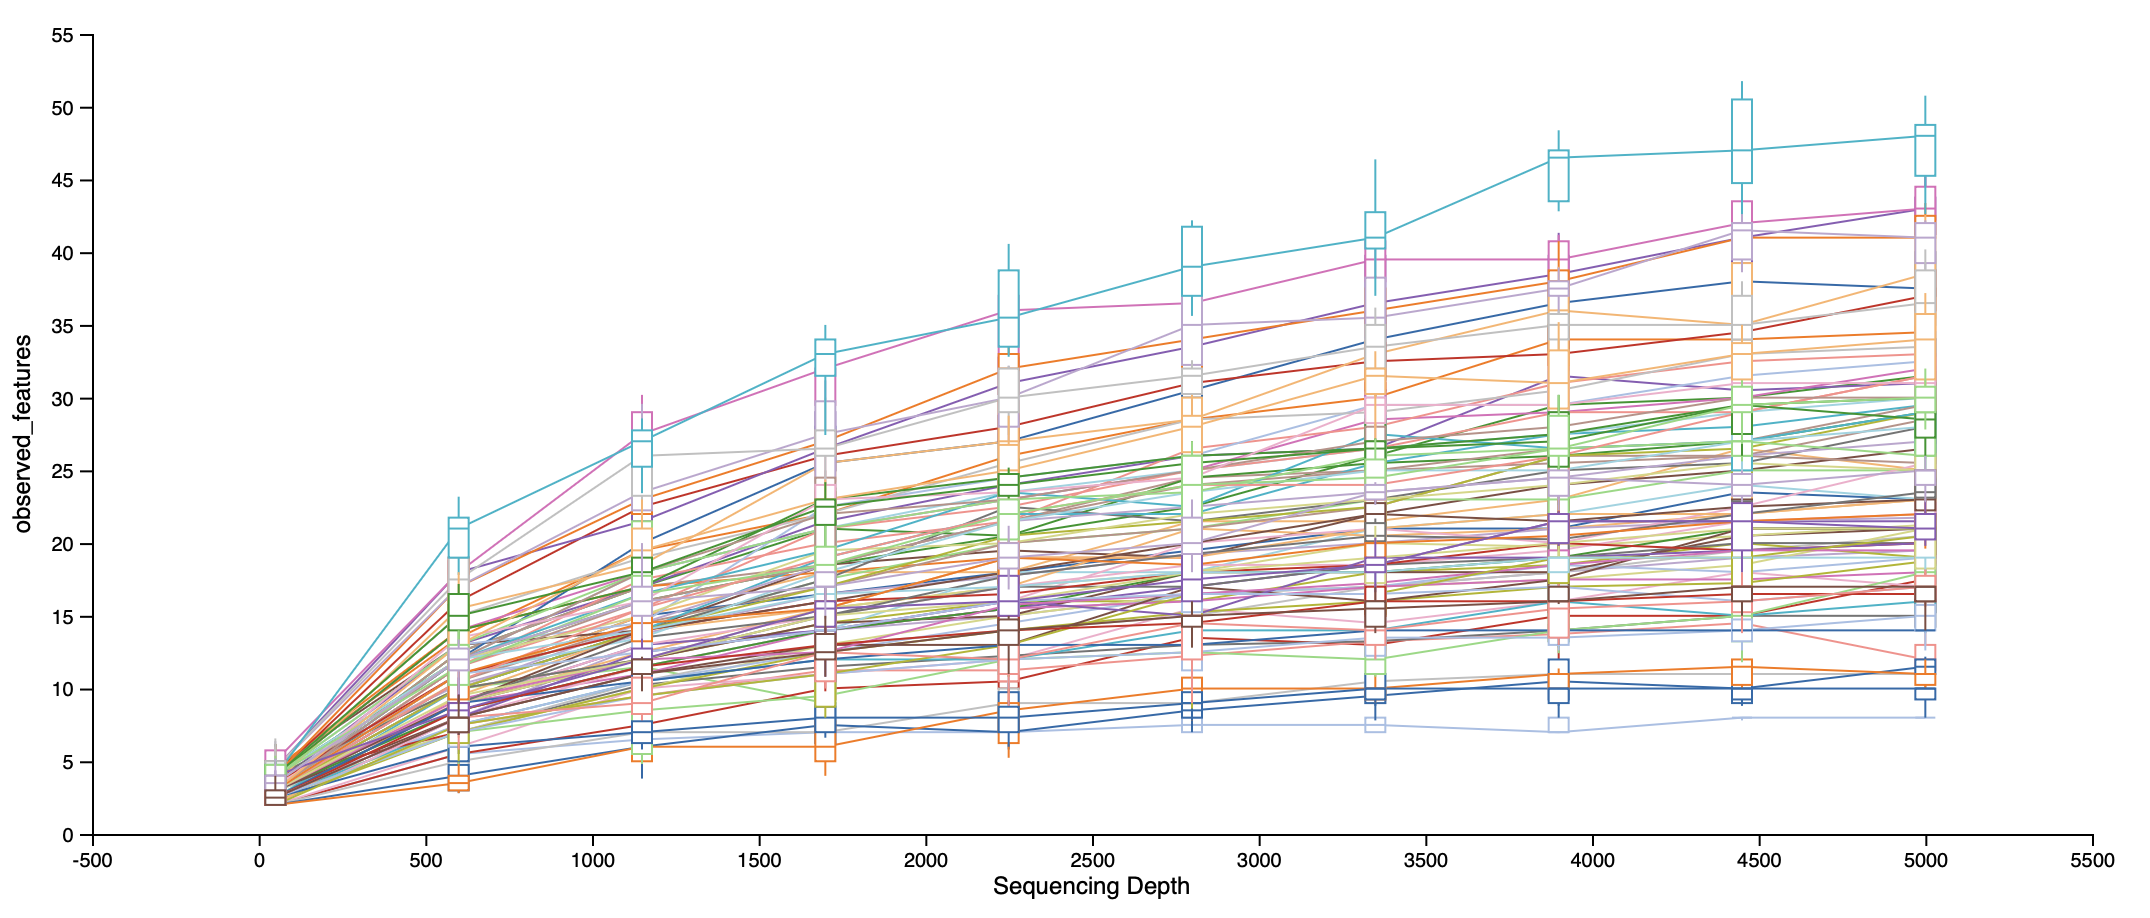

In [6]:
pwd

'/Users/meyeanni/Desktop/git_sourdough/SourdoughFlow/LP4/shipping_analysis/shipping_data'

In [7]:
! qiime diversity alpha-rarefaction \
    --i-table ITS/ASVs/fungi-table-shipping-filt-5.qza \
    --p-min-depth 100 \
    --p-max-depth 5000 \
    --p-steps 49 \
    --m-metadata-file ITS/shipping_general_metadata.tsv  \
    --o-visualization ITS/ASVs/alpha_rarefaction/alpha-rarefaction-curves-2.qzv

fatal: bad revision 'HEAD'
fatal: bad revision 'HEAD'
/Users/meyeanni/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/qiime2/metadata/io.py:365: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  series = series.replace('', np.nan).infer_objects(copy=False)
Saved Visualization to: ITS/ASVs/alpha_rarefaction/alpha-rarefaction-curves-2.qzv


In [8]:
import zipfile

with zipfile.ZipFile("ITS/ASVs/alpha_rarefaction/alpha-rarefaction-curves-2.qzv", 'r') as zip_ref:
    zip_ref.extractall("ITS/ASVs/alpha_rarefaction/rarefaction_data")

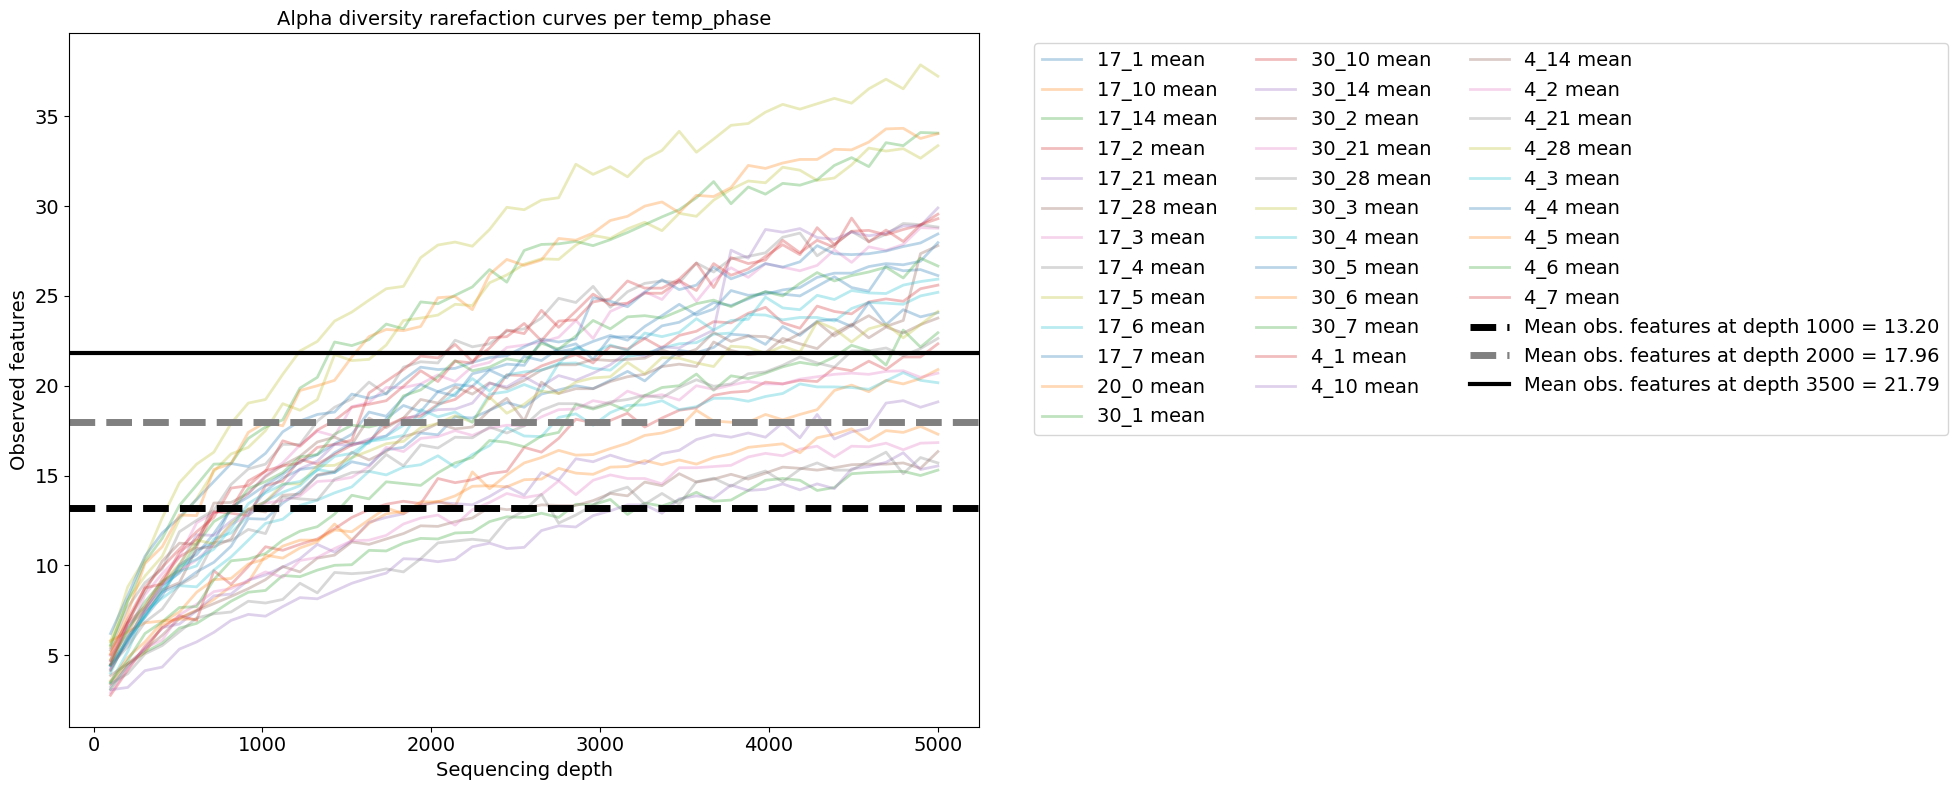

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and reshape
df = pd.read_csv("ITS/ASVs/alpha_rarefaction/rarefaction_data/e84b5adb-6ad2-496d-831e-956857411246/data/observed_features.csv")
depth_cols = [col for col in df.columns if col.startswith('depth-')]
df_melted = df.melt(id_vars=['sample-id', 'temp_phase'],
                    value_vars=depth_cols,
                    var_name='depth_iter', value_name='alpha_diversity')
df_melted['depth'] = df_melted['depth_iter'].str.extract(r'depth-(\d+)_')[0].astype(int)

# Medians
means = df_melted.groupby(['temp_phase', 'depth'])['alpha_diversity'].mean().reset_index()

# Mean lines at specific depths
mean_alpha_380 = df_melted[df_melted['depth'] == 1018]['alpha_diversity'].mean()
mean_alpha_1000 = df_melted[df_melted['depth'] == 2039]['alpha_diversity'].mean()
mean_alpha_2000 = df_melted[df_melted['depth'] == 3468]['alpha_diversity'].mean()

# Plot
plt.figure(figsize=(20, 8))

# Only lines per temp_phase
for temp_phase in means['temp_phase'].unique():
    temp_df = means[means['temp_phase'] == temp_phase]
    plt.plot(temp_df['depth'], temp_df['alpha_diversity'],
             linewidth=2, label=f"{temp_phase} mean", alpha = 0.3)

# Horizontal lines
plt.axhline(y=mean_alpha_380, color='black', linestyle='--', linewidth=5,
            label=f"Mean obs. features at depth 1000 = {mean_alpha_380:.2f}")
plt.axhline(y=mean_alpha_1000, color='gray', linestyle='--', linewidth=5,
            label=f"Mean obs. features at depth 2000 = {mean_alpha_1000:.2f}")
plt.axhline(y=mean_alpha_2000, color='black', linestyle='-', linewidth=3,
            label=f"Mean obs. features at depth 3500 = {mean_alpha_2000:.2f}")


# Labels and layout
plt.title("Alpha diversity rarefaction curves per temp_phase", fontsize = 14)
plt.xlabel("Sequencing depth", fontsize = 14)
plt.ylabel("Observed features", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol = 3, fontsize = 14)
plt.tight_layout()
plt.show()

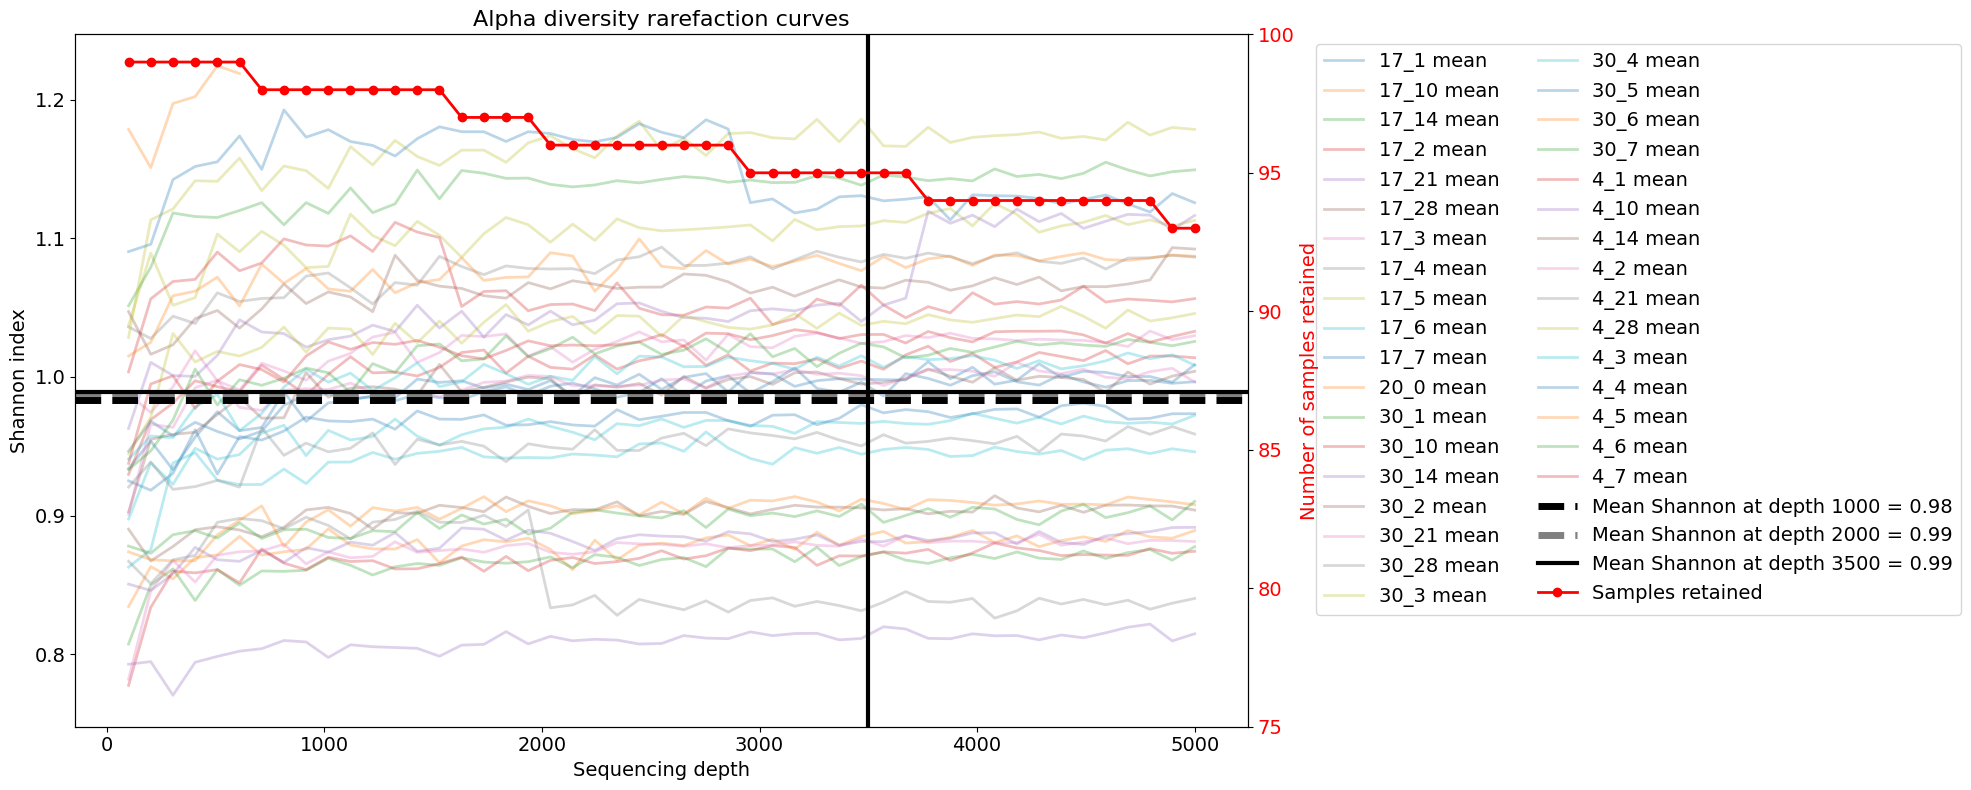

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and reshape
df = pd.read_csv("ITS/ASVs/alpha_rarefaction/rarefaction_data/e84b5adb-6ad2-496d-831e-956857411246/data/shannon.csv")
depth_cols = [col for col in df.columns if col.startswith('depth-')]
df_melted = df.melt(id_vars=['sample-id', 'temp_phase'],
                    value_vars=depth_cols,
                    var_name='depth_iter', value_name='alpha_diversity')
df_melted['depth'] = df_melted['depth_iter'].str.extract(r'depth-(\d+)_')[0].astype(int)

# Means per temp_phase
means = df_melted.groupby(['temp_phase', 'depth'])['alpha_diversity'].mean().reset_index()

# Sample count per depth
sample_counts = df_melted.groupby('depth')['alpha_diversity'].count().reset_index()
sample_counts['n_samples'] = sample_counts['alpha_diversity'] / 10
sample_counts.drop(columns='alpha_diversity', inplace=True)

sample_counts.rename(columns={'alpha_diversity': 'n_samples'}, inplace=True)

# Mean lines at specific depths
mean_alpha_380 = df_melted[df_melted['depth'] == 1018]['alpha_diversity'].mean()
mean_alpha_1000 = df_melted[df_melted['depth'] == 2039]['alpha_diversity'].mean()
mean_alpha_2000 = df_melted[df_melted['depth'] == 3468]['alpha_diversity'].mean()


# Plot setup
fig, ax1 = plt.subplots(figsize=(20, 8))

# Main plot: alpha diversity
for temp_phase in means['temp_phase'].unique():
    temp_df = means[means['temp_phase'] == temp_phase]
    ax1.plot(temp_df['depth'], temp_df['alpha_diversity'],
             linewidth=2, label=f"{temp_phase} mean", alpha=0.3)

# Horizontal lines
ax1.axhline(y=mean_alpha_380, color='black', linestyle='--', linewidth=5,
            label=f"Mean Shannon at depth 1000 = {mean_alpha_380:.2f}")
ax1.axhline(y=mean_alpha_1000, color='gray', linestyle='--', linewidth=5,
            label=f"Mean Shannon at depth 2000 = {mean_alpha_1000:.2f}")
ax1.axhline(y=mean_alpha_2000, color='black', linestyle='-', linewidth=3,
            label=f"Mean Shannon at depth 3500 = {mean_alpha_2000:.2f}")
ax1.axvline(x = 3500, color='black', linestyle='-', linewidth=3,
            label=f"")

ax1.set_xlabel("Sequencing depth", fontsize=14)
ax1.set_ylabel("Shannon index", fontsize=14)
ax1.tick_params(axis='both', labelsize=14)

# Second y-axis for sample count
ax2 = ax1.twinx()
ax2.plot(sample_counts['depth'], sample_counts['n_samples'], color='red', marker='o',
         label='Samples retained', linewidth=2)
ax2.set_ylabel("Number of samples retained", fontsize=14, color='red')
ax2.tick_params(axis='y', labelcolor='red', labelsize=14)
ax2.set_ylim(75, 100)


# Legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2,
           bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize=14)

plt.title("Alpha diversity rarefaction curves", fontsize=16)
plt.tight_layout()
plt.savefig("ITS/ASVs/alpha_rarefaction/rarefaction_data/e84b5adb-6ad2-496d-831e-956857411246/data/20250611_alpha_rarefaction_shannon.pdf", dpi=300, bbox_inches='tight')
plt.show()

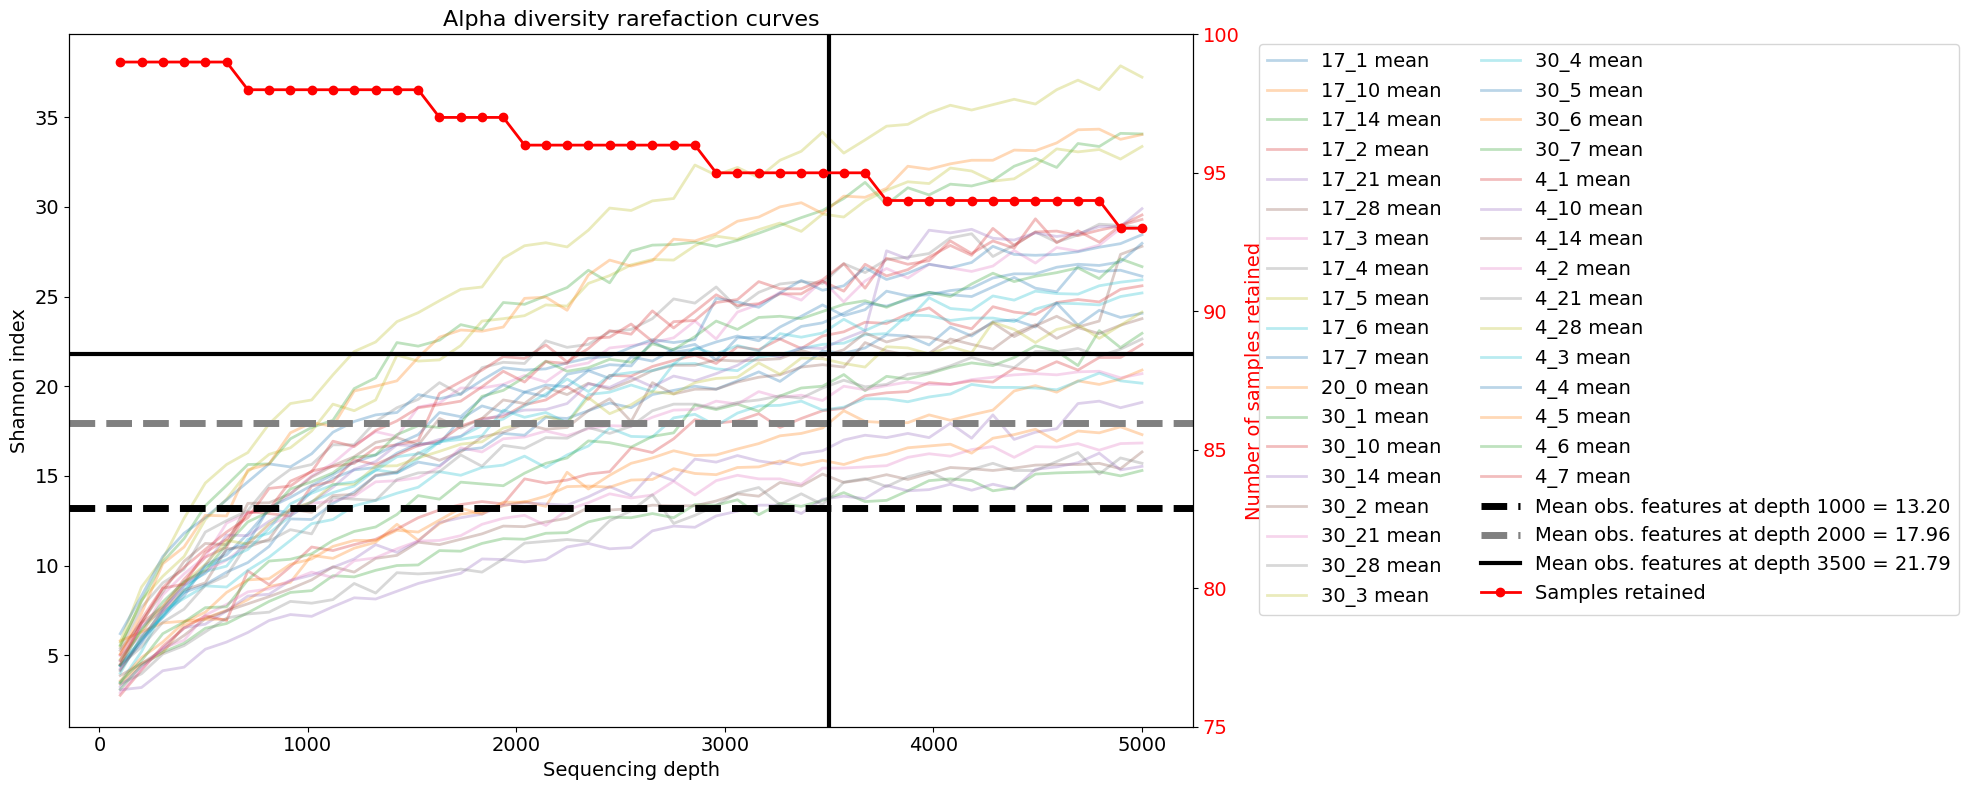

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and reshape
df = pd.read_csv("ITS/ASVs/alpha_rarefaction/rarefaction_data/e84b5adb-6ad2-496d-831e-956857411246/data/observed_features.csv")
depth_cols = [col for col in df.columns if col.startswith('depth-')]
df_melted = df.melt(id_vars=['sample-id', 'temp_phase'],
                    value_vars=depth_cols,
                    var_name='depth_iter', value_name='alpha_diversity')
df_melted['depth'] = df_melted['depth_iter'].str.extract(r'depth-(\d+)_')[0].astype(int)

# Means per temp_phase
means = df_melted.groupby(['temp_phase', 'depth'])['alpha_diversity'].mean().reset_index()

# Sample count per depth
sample_counts = df_melted.groupby('depth')['alpha_diversity'].count().reset_index()
sample_counts['n_samples'] = sample_counts['alpha_diversity'] / 10
sample_counts.drop(columns='alpha_diversity', inplace=True)

sample_counts.rename(columns={'alpha_diversity': 'n_samples'}, inplace=True)

# Mean lines at specific depths
mean_alpha_380 = df_melted[df_melted['depth'] == 1018]['alpha_diversity'].mean()
mean_alpha_1000 = df_melted[df_melted['depth'] == 2039]['alpha_diversity'].mean()
mean_alpha_2000 = df_melted[df_melted['depth'] == 3468]['alpha_diversity'].mean()

# Plot setup
fig, ax1 = plt.subplots(figsize=(20, 8))

# Main plot: alpha diversity
for temp_phase in means['temp_phase'].unique():
    temp_df = means[means['temp_phase'] == temp_phase]
    ax1.plot(temp_df['depth'], temp_df['alpha_diversity'],
             linewidth=2, label=f"{temp_phase} mean", alpha=0.3)

# Horizontal lines
ax1.axhline(y=mean_alpha_380, color='black', linestyle='--', linewidth=5,
            label=f"Mean obs. features at depth 1000 = {mean_alpha_380:.2f}")
ax1.axhline(y=mean_alpha_1000, color='gray', linestyle='--', linewidth=5,
            label=f"Mean obs. features at depth 2000 = {mean_alpha_1000:.2f}")
ax1.axhline(y=mean_alpha_2000, color='black', linestyle='-', linewidth=3,
            label=f"Mean obs. features at depth 3500 = {mean_alpha_2000:.2f}")
ax1.axvline(x = 3500, color='black', linestyle='-', linewidth=3,
            label=f"")

ax1.set_xlabel("Sequencing depth", fontsize=14)
ax1.set_ylabel("Shannon index", fontsize=14)
ax1.tick_params(axis='both', labelsize=14)

# Second y-axis for sample count
ax2 = ax1.twinx()
ax2.plot(sample_counts['depth'], sample_counts['n_samples'], color='red', marker='o',
         label='Samples retained', linewidth=2)
ax2.set_ylabel("Number of samples retained", fontsize=14, color='red')
ax2.tick_params(axis='y', labelcolor='red', labelsize=14)
ax2.set_ylim(75, 100)


# Legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2,
           bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize=14)

plt.title("Alpha diversity rarefaction curves", fontsize=16)
plt.tight_layout()
plt.savefig("ITS/ASVs/alpha_rarefaction/rarefaction_data/e84b5adb-6ad2-496d-831e-956857411246/data/20250611_alpha_rarefaction_observed_features.pdf", dpi=300, bbox_inches='tight')
plt.show()

go with 3500 and then spike in the ones that have less than 3500 reads

In [5]:
! qiime diversity core-metrics \
  --i-table ASVs/fungi-table-shipping-filt-5.qza \
  --m-metadata-file shipping_general_metadata.tsv \
  --p-sampling-depth 3500 \
  --output-dir ASVs/alpha_rarefaction/core-metrics-results-1000

/home/meyeanni/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/qiime2/metadata/io.py:365: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  series = series.replace('', np.nan).infer_objects(copy=False)
Saved FeatureTable[Frequency] to: ASVs/alpha_rarefaction/core-metrics-results-1000/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: ASVs/alpha_rarefaction/core-metrics-results-1000/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: ASVs/alpha_rarefaction/core-metrics-results-1000/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: ASVs/alpha_rarefaction/core-metrics-results-1000/evenness_vector.qza
Saved DistanceMatrix to: ASVs/alpha_rarefaction/core-metrics-results-1000/jaccard_distance_matrix.qza
Saved DistanceMatri

In [6]:
! qiime feature-table filter-samples \
  --i-table ASVs/fungi-table-shipping-filt-5.qza \
  --p-max-frequency 3499 \
  --o-filtered-table ASVs/samples_less_than_3500_reads.qza

Saved FeatureTable[Frequency] to: ASVs/samples_less_than_3500_reads.qza


In [7]:
from qiime2 import Artifact
from qiime2.plugins.feature_table.methods import relative_frequency

# Load your feature table artifact
feature_table = Artifact.load("ASVs/alpha_rarefaction/core-metrics-results-1000/rarefied_table.qza")

# Normalize the feature table to relative frequencies
relative_freq_table = relative_frequency(table=feature_table)

# Extract the relative frequency feature table
relative_freq_table = relative_freq_table.relative_frequency_table

relative_freq_table.save("ASVs/alpha_rarefaction/core-metrics-results-1000/relative_frequency_table.qza")

'ASVs/alpha_rarefaction/core-metrics-results-1000/relative_frequency_table.qza'

In [8]:
from qiime2 import Artifact
from qiime2.plugins.feature_table.methods import relative_frequency

# Load your feature table artifact
feature_table = Artifact.load("ASVs/samples_less_than_3500_reads.qza")

# Normalize the feature table to relative frequencies
relative_freq_table = relative_frequency(table=feature_table)

# Extract the relative frequency feature table
relative_freq_table = relative_freq_table.relative_frequency_table

relative_freq_table.save("ASVs/alpha_rarefaction/core-metrics-results-1000/relative_frequency_table_less_than_1000_reads.qza")

'ASVs/alpha_rarefaction/core-metrics-results-1000/relative_frequency_table_less_than_1000_reads.qza'

### Then make the same for OTUs, also 1000 reads and spike in the ones that do not pass

In [9]:
! qiime diversity alpha-rarefaction \
    --i-table OTUs/clustered-table-UNITE90-shipping-filt-1.qza \
    --p-min-depth 50 \
    --p-max-depth 5000 \
    --m-metadata-file shipping_general_metadata.tsv  \
    --o-visualization OTUs/alpha_rarefaction/alpha-rarefaction-curves.qzv

/home/meyeanni/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/qiime2/metadata/io.py:365: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  series = series.replace('', np.nan).infer_objects(copy=False)
Saved Visualization to: OTUs/alpha_rarefaction/alpha-rarefaction-curves.qzv


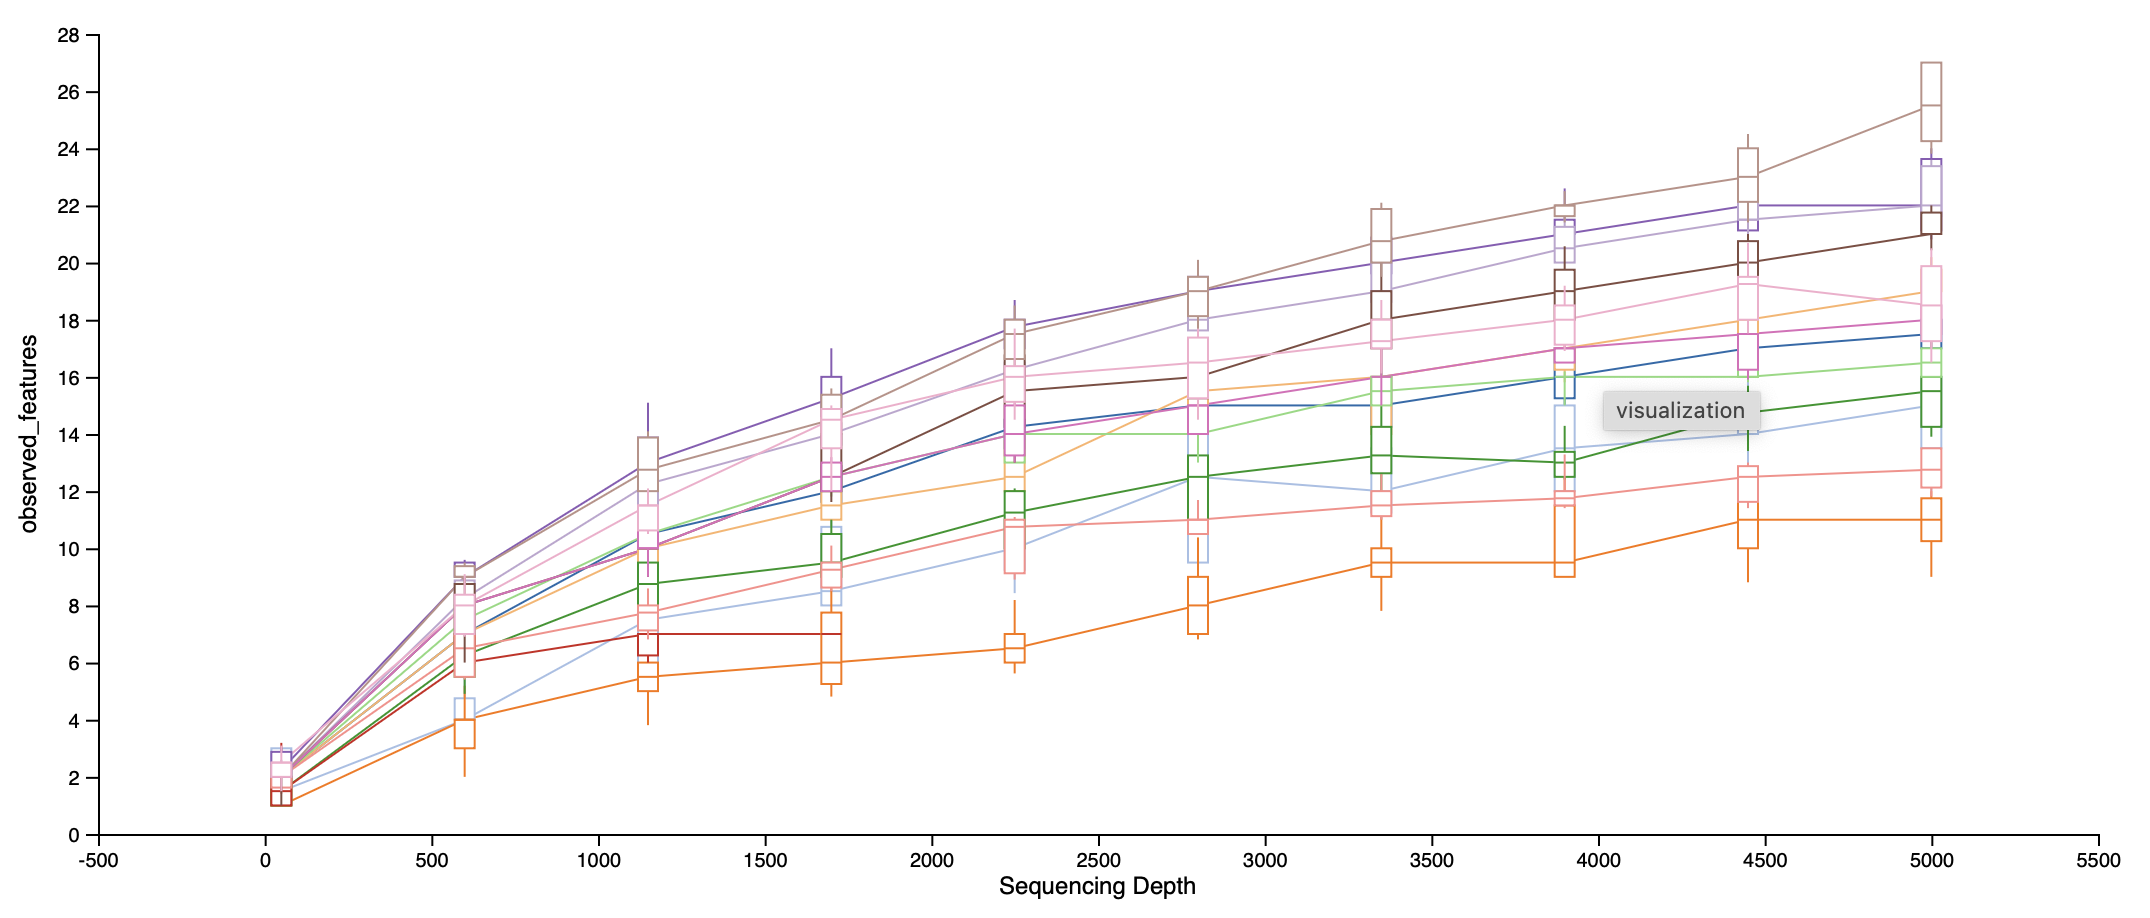

-->> also go with 3500

In [10]:
! qiime diversity core-metrics \
  --i-table OTUs/clustered-table-UNITE90-shipping-filt-1.qza \
  --m-metadata-file shipping_general_metadata.tsv \
  --p-sampling-depth 3500 \
  --output-dir OTUs/alpha_rarefaction/core-metrics-results-1000

/home/meyeanni/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/qiime2/metadata/io.py:365: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  series = series.replace('', np.nan).infer_objects(copy=False)
Saved FeatureTable[Frequency] to: OTUs/alpha_rarefaction/core-metrics-results-1000/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: OTUs/alpha_rarefaction/core-metrics-results-1000/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: OTUs/alpha_rarefaction/core-metrics-results-1000/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: OTUs/alpha_rarefaction/core-metrics-results-1000/evenness_vector.qza
Saved DistanceMatrix to: OTUs/alpha_rarefaction/core-metrics-results-1000/jaccard_distance_matrix.qza
Saved DistanceMatri

In [16]:
! qiime feature-table filter-samples \
  --i-table OTUs/clustered-table-UNITE90-shipping-filt-1.qza \
  --p-max-frequency 3499 \
  --o-filtered-table OTUs/samples_less_than_3500_reads.qza

Saved FeatureTable[Frequency] to: OTUs/samples_less_than_3500_reads.qza


In [12]:
from qiime2 import Artifact
from qiime2.plugins.feature_table.methods import relative_frequency

# Load your feature table artifact
feature_table = Artifact.load("OTUs/alpha_rarefaction/core-metrics-results-1000/rarefied_table.qza")

# Normalize the feature table to relative frequencies
relative_freq_table = relative_frequency(table=feature_table)

# Extract the relative frequency feature table
relative_freq_table = relative_freq_table.relative_frequency_table

relative_freq_table.save("OTUs/alpha_rarefaction/core-metrics-results-1000/relative_frequency_table.qza")

'OTUs/alpha_rarefaction/core-metrics-results-1000/relative_frequency_table.qza'

In [13]:
from qiime2 import Artifact
from qiime2.plugins.feature_table.methods import relative_frequency

# Load your feature table artifact
feature_table = Artifact.load("OTUs/samples_less_than_3499_reads.qza")

# Normalize the feature table to relative frequencies
relative_freq_table = relative_frequency(table=feature_table)

# Extract the relative frequency feature table
relative_freq_table = relative_freq_table.relative_frequency_table

relative_freq_table.save("OTUs/alpha_rarefaction/core-metrics-results-1000/relative_frequency_table_less_than_1000_reads.qza")

'OTUs/alpha_rarefaction/core-metrics-results-1000/relative_frequency_table_less_than_1000_reads.qza'

### Then use the prevalence/abundance filter to remove very rare taxa that should not be in there (probably, since those should be triplicates anyways..)

in at least 2 samples, and features have need to have an abundance of at least 20 reads across all samples

In [14]:
#instead of later processing in python, try the prevalence and abundance filtering in qiime2 for all above tables:
! qiime feature-table filter-features \
  --i-table ASVs/alpha_rarefaction/core-metrics-results-1000/rarefied_table.qza \
  --p-min-samples 2 \
  --p-min-frequency 20 \
  --o-filtered-table ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_table.qza

Saved FeatureTable[Frequency] to: ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_table.qza


In [17]:
! qiime feature-table filter-features \
  --i-table ASVs/samples_less_than_3500_reads.qza \
  --p-min-samples 1 \
  --p-min-frequency 20 \
  --o-filtered-table ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_samples_less_than_1000_reads.qza

Saved FeatureTable[Frequency] to: ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_samples_less_than_1000_reads.qza


In [18]:
#also create a combined version of the two tables:
! qiime feature-table merge \
  --i-tables ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_table.qza ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_samples_less_than_1000_reads.qza \
  --p-overlap-method sum \
  --o-merged-table ASVs/alpha_rarefaction/core-metrics-results-1000/merged_table.qza

Saved FeatureTable[Frequency] to: ASVs/alpha_rarefaction/core-metrics-results-1000/merged_table.qza


In [19]:
#recalculate jaccard and bray curtis distances for the filtered tables (all three above), without rarefaction:
! qiime diversity beta --i-table ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_table.qza --p-metric jaccard --o-distance-matrix ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_table_jaccard_distance_matrix.qza
! qiime diversity beta --i-table ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_table.qza --p-metric braycurtis --o-distance-matrix ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_table_braycurtis_distance_matrix.qza

#and then for the merged one:
! qiime diversity beta --i-table ASVs/alpha_rarefaction/core-metrics-results-1000/merged_table.qza --p-metric jaccard --o-distance-matrix ASVs/alpha_rarefaction/core-metrics-results-1000/merged_table_jaccard_distance_matrix.qza
! qiime diversity beta --i-table ASVs/alpha_rarefaction/core-metrics-results-1000/merged_table.qza --p-metric braycurtis --o-distance-matrix ASVs/alpha_rarefaction/core-metrics-results-1000/merged_table_braycurtis_distance_matrix.qza

Saved DistanceMatrix to: ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_table_jaccard_distance_matrix.qza
Saved DistanceMatrix to: ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_table_braycurtis_distance_matrix.qza
Saved DistanceMatrix to: ASVs/alpha_rarefaction/core-metrics-results-1000/merged_table_jaccard_distance_matrix.qza
Saved DistanceMatrix to: ASVs/alpha_rarefaction/core-metrics-results-1000/merged_table_braycurtis_distance_matrix.qza


In [20]:
# Example for filtered table
! qiime diversity alpha \
  --i-table ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_table.qza \
  --p-metric shannon \
  --o-alpha-diversity ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_table_shannon.qza

! qiime diversity alpha \
  --i-table ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_table.qza \
  --p-metric simpson \
  --o-alpha-diversity ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_table_simpson.qza

! qiime diversity alpha \
  --i-table ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_table.qza \
  --p-metric chao1 \
  --o-alpha-diversity ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_table_chao1.qza



! qiime diversity alpha \
  --i-table ASVs/alpha_rarefaction/core-metrics-results-1000/merged_table.qza \
  --p-metric shannon \
  --o-alpha-diversity ASVs/alpha_rarefaction/core-metrics-results-1000/merged_table_shannon.qza

! qiime diversity alpha \
  --i-table ASVs/alpha_rarefaction/core-metrics-results-1000/merged_table.qza \
  --p-metric simpson \
  --o-alpha-diversity ASVs/alpha_rarefaction/core-metrics-results-1000/merged_table_simpson.qza

! qiime diversity alpha \
  --i-table ASVs/alpha_rarefaction/core-metrics-results-1000/merged_table.qza \
  --p-metric chao1 \
  --o-alpha-diversity ASVs/alpha_rarefaction/core-metrics-results-1000/merged_table_chao1.qza  


Saved SampleData[AlphaDiversity] to: ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_table_shannon.qza
Saved SampleData[AlphaDiversity] to: ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_table_simpson.qza
Saved SampleData[AlphaDiversity] to: ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_table_chao1.qza
Saved SampleData[AlphaDiversity] to: ASVs/alpha_rarefaction/core-metrics-results-1000/merged_table_shannon.qza
Saved SampleData[AlphaDiversity] to: ASVs/alpha_rarefaction/core-metrics-results-1000/merged_table_simpson.qza
Saved SampleData[AlphaDiversity] to: ASVs/alpha_rarefaction/core-metrics-results-1000/merged_table_chao1.qza


### and then do exactly the same for the OTUs

In [21]:
#instead of later processing in python, try the prevalence and abundance filtering in qiime2 for all above tables:
! qiime feature-table filter-features \
  --i-table OTUs/alpha_rarefaction/core-metrics-results-1000/rarefied_table.qza \
  --p-min-samples 2 \
  --p-min-frequency 20 \
  --o-filtered-table OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_table.qza

Saved FeatureTable[Frequency] to: OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_table.qza


In [22]:
! qiime feature-table filter-features \
  --i-table OTUs/samples_less_than_3499_reads.qza \
  --p-min-samples 1 \
  --p-min-frequency 20 \
  --o-filtered-table OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_samples_less_than_1000_reads.qza

Saved FeatureTable[Frequency] to: OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_samples_less_than_1000_reads.qza


In [23]:
#also create a combined version of the two tables:
! qiime feature-table merge \
  --i-tables OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_table.qza OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_samples_less_than_1000_reads.qza \
  --p-overlap-method sum \
  --o-merged-table OTUs/alpha_rarefaction/core-metrics-results-1000/merged_table.qza

Saved FeatureTable[Frequency] to: OTUs/alpha_rarefaction/core-metrics-results-1000/merged_table.qza


In [24]:
#recalculate jaccard and bray curtis distances for the filtered tables (all three above), without rarefaction:
! qiime diversity beta --i-table OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_table.qza --p-metric jaccard --o-distance-matrix OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_table_jaccard_distance_matrix.qza
! qiime diversity beta --i-table OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_table.qza --p-metric braycurtis --o-distance-matrix OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_table_braycurtis_distance_matrix.qza

#and then for the merged one:
! qiime diversity beta --i-table OTUs/alpha_rarefaction/core-metrics-results-1000/merged_table.qza --p-metric jaccard --o-distance-matrix OTUs/alpha_rarefaction/core-metrics-results-1000/merged_table_jaccard_distance_matrix.qza
! qiime diversity beta --i-table OTUs/alpha_rarefaction/core-metrics-results-1000/merged_table.qza --p-metric braycurtis --o-distance-matrix OTUs/alpha_rarefaction/core-metrics-results-1000/merged_table_braycurtis_distance_matrix.qza

Saved DistanceMatrix to: OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_table_jaccard_distance_matrix.qza
Saved DistanceMatrix to: OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_table_braycurtis_distance_matrix.qza
Saved DistanceMatrix to: OTUs/alpha_rarefaction/core-metrics-results-1000/merged_table_jaccard_distance_matrix.qza
Saved DistanceMatrix to: OTUs/alpha_rarefaction/core-metrics-results-1000/merged_table_braycurtis_distance_matrix.qza


In [25]:
# Example for filtered table
! qiime diversity alpha \
  --i-table OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_table.qza \
  --p-metric shannon \
  --o-alpha-diversity OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_table_shannon.qza

! qiime diversity alpha \
  --i-table OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_table.qza \
  --p-metric simpson \
  --o-alpha-diversity OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_table_simpson.qza

! qiime diversity alpha \
  --i-table OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_table.qza \
  --p-metric chao1 \
  --o-alpha-diversity OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_table_chao1.qza



! qiime diversity alpha \
  --i-table OTUs/alpha_rarefaction/core-metrics-results-1000/merged_table.qza \
  --p-metric shannon \
  --o-alpha-diversity OTUs/alpha_rarefaction/core-metrics-results-1000/merged_table_shannon.qza

! qiime diversity alpha \
  --i-table OTUs/alpha_rarefaction/core-metrics-results-1000/merged_table.qza \
  --p-metric simpson \
  --o-alpha-diversity OTUs/alpha_rarefaction/core-metrics-results-1000/merged_table_simpson.qza

! qiime diversity alpha \
  --i-table OTUs/alpha_rarefaction/core-metrics-results-1000/merged_table.qza \
  --p-metric chao1 \
  --o-alpha-diversity OTUs/alpha_rarefaction/core-metrics-results-1000/merged_table_chao1.qza  

Saved SampleData[AlphaDiversity] to: OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_table_shannon.qza
Saved SampleData[AlphaDiversity] to: OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_table_simpson.qza
Saved SampleData[AlphaDiversity] to: OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_table_chao1.qza
Saved SampleData[AlphaDiversity] to: OTUs/alpha_rarefaction/core-metrics-results-1000/merged_table_shannon.qza
Saved SampleData[AlphaDiversity] to: OTUs/alpha_rarefaction/core-metrics-results-1000/merged_table_simpson.qza
Saved SampleData[AlphaDiversity] to: OTUs/alpha_rarefaction/core-metrics-results-1000/merged_table_chao1.qza


### then make new relative frequency tables with the filtered feature tables

In [26]:
from qiime2 import Artifact
from qiime2.plugins.feature_table.methods import relative_frequency

# Load your feature table artifact
feature_table = Artifact.load("ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_table.qza")

# Normalize the feature table to relative frequencies
relative_freq_table = relative_frequency(table=feature_table)

# Extract the relative frequency feature table
relative_freq_table = relative_freq_table.relative_frequency_table

relative_freq_table.save("ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_relative_frequency_table.qza")

'ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_relative_frequency_table.qza'

In [27]:
from qiime2 import Artifact
from qiime2.plugins.feature_table.methods import relative_frequency

# Load your feature table artifact
feature_table = Artifact.load("ASVs/alpha_rarefaction/core-metrics-results-1000/merged_table.qza")

# Normalize the feature table to relative frequencies
relative_freq_table = relative_frequency(table=feature_table)

# Extract the relative frequency feature table
relative_freq_table = relative_freq_table.relative_frequency_table

relative_freq_table.save("ASVs/alpha_rarefaction/core-metrics-results-1000/merged_relative_frequency_table.qza")

'ASVs/alpha_rarefaction/core-metrics-results-1000/merged_relative_frequency_table.qza'

In [28]:
from qiime2 import Artifact
from qiime2.plugins.feature_table.methods import relative_frequency

# Load your feature table artifact
feature_table = Artifact.load("OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_table.qza")

# Normalize the feature table to relative frequencies
relative_freq_table = relative_frequency(table=feature_table)

# Extract the relative frequency feature table
relative_freq_table = relative_freq_table.relative_frequency_table

relative_freq_table.save("OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_relative_frequency_table.qza")

'OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_relative_frequency_table.qza'

In [29]:
from qiime2 import Artifact
from qiime2.plugins.feature_table.methods import relative_frequency

# Load your feature table artifact
feature_table = Artifact.load("OTUs/alpha_rarefaction/core-metrics-results-1000/merged_table.qza")

# Normalize the feature table to relative frequencies
relative_freq_table = relative_frequency(table=feature_table)

# Extract the relative frequency feature table
relative_freq_table = relative_freq_table.relative_frequency_table

relative_freq_table.save("OTUs/alpha_rarefaction/core-metrics-results-1000/merged_relative_frequency_table.qza")

'OTUs/alpha_rarefaction/core-metrics-results-1000/merged_relative_frequency_table.qza'

load metadata

In [30]:
metadata_ITS = pd.read_csv("shipping_general_metadata.tsv", index_col=0, sep="\t")



In [31]:
metadata_ITS

label_barcode1 label_barcode2      created_date  \
SampleID                                                                  
366292_209-LP4-ITS-0709   ACCCGAGGCCTC   CAAATGGTCGTC  16.10.2024 14:59   
366292_255-LP4-ITS-0755   AGGGCGAAGAAG   AATATCGGGATC  16.10.2024 14:59   
366292_237-LP4-ITS-0737   GTCCCGTCGGGT   GTCAATTAGTGG  16.10.2024 14:59   
366292_198-LP4-ITS-0698   TGGACTTACCAG   TTGCGACAAAGT  16.10.2024 14:59   
366292_240-LP4-ITS-0740   CGCCTCCTATGG   AGAAGGCCTTAT  16.10.2024 14:59   
...                                ...            ...               ...   
366292_231-LP4-ITS-0731   AGGGCGAAGAAG   GGCCTATAAGTC  16.10.2024 14:59   
366292_245-LP4-ITS-0745   GTCCCGTCGGGT   CCTAAGAGCATC  16.10.2024 14:59   
366292_252-LP4-ITS-0752   TATTGAATATTG   TAGTGTCGGATC  16.10.2024 14:59   
366292_212-LP4-ITS-0712   TATTGAATATTG   GGCAGTGTTAAT  16.10.2024 14:59   
366292_128-LP4-ITS-0628   AGACCGTCAGAC   CGCGGCGCAGCT  16.10.2024 14:59   

                        amplicon     unique_id  sample_id plate  \
SampleID                                                          
366292_209-LP4-ITS-0709      ITS  LP4-ITS-0709  W00.00.00    P8   
366292_255-LP4-ITS-0755      ITS  LP4-ITS-0755  W04.01.01    P8   
366292_237-LP4-ITS-0737      ITS  LP4-ITS-0737  W04.01.02    P8   
366292_198-LP4-ITS-0698      ITS  LP4-ITS-0698  W04.01.03    P8   
366292_240-LP4-ITS-0740      ITS  LP4-ITS-0740  W04.01.04    P8   
...                          ...           ...        ...   ...   
366292_231-LP4-ITS-0731      ITS  LP4-ITS-0731  W30.03.06    P8   
366292_245-LP4-ITS-0745      ITS  LP4-ITS-0745  W30.03.10    P8   
366292_252-LP4-ITS-0752      ITS  LP4-ITS-0752  W30.03.14    P8   
366292_212-LP4-ITS-0712      ITS  LP4-ITS-0712  W30.03.21    P8   
366292_128-LP4-ITS-0628      ITS  LP4-ITS-0628  W30.03.28    P7   

                        plate_position  amplicon_conc DNA_extraction_plate  \
SampleID                                                                     
366292_209-LP4-ITS-0709            E05       1.184620                DNA74   
366292_255-LP4-ITS-0755            C11      18.154860                DNA74   
366292_237-LP4-ITS-0737            A09       5.543120                DNA74   
366292_198-LP4-ITS-0698            B04      14.986790                DNA74   
366292_240-LP4-ITS-0740            D09      15.458240                DNA74   
...                                ...            ...                  ...   
366292_231-LP4-ITS-0731            C08      16.604110                DNA74   
366292_245-LP4-ITS-0745            A10      10.094150                DNA74   
366292_252-LP4-ITS-0752            H10      24.542690                DNA74   
366292_212-LP4-ITS-0712            H05      16.688820                DNA74   
366292_128-LP4-ITS-0628            D07       0.854114                DNA61   

                          project sample_type  day  temperature  hand  \
SampleID                                                                
366292_209-LP4-ITS-0709  shipping   sourdough    0           20   NaN   
366292_255-LP4-ITS-0755  shipping   sourdough    1            4   NaN   
366292_237-LP4-ITS-0737  shipping   sourdough    2            4   NaN   
366292_198-LP4-ITS-0698  shipping   sourdough    3            4   NaN   
366292_240-LP4-ITS-0740  shipping   sourdough    4            4   NaN   
...                           ...         ...  ...          ...   ...   
366292_231-LP4-ITS-0731  shipping   sourdough    6           30   NaN   
366292_245-LP4-ITS-0745  shipping   sourdough   10           30   NaN   
366292_252-LP4-ITS-0752  shipping   sourdough   14           30   NaN   
366292_212-LP4-ITS-0712  shipping   sourdough   21           30   NaN   
366292_128-LP4-ITS-0628  shipping   sourdough   28           30   NaN   

                        decontam_1 decontam_2  UniqueFeaturesCount  \
SampleID                                                             
366292_209-LP4-ITS-0709     sample     sample                    8   
3

### then import distance matrices

ASVs:

In [32]:
import qiime2
from skbio.stats.distance import permanova, DistanceMatrix

#load distance matrices for LP5 (both the non-merged and merged tables):
#jaccard:
jaccard_dm_ITS_ASV = qiime2.Artifact.load('ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_table_jaccard_distance_matrix.qza')
jaccard_dm_ITS_ASV = jaccard_dm_ITS_ASV.view(DistanceMatrix)

jaccard_dm_ITS_ASV_merged = qiime2.Artifact.load('ASVs/alpha_rarefaction/core-metrics-results-1000/merged_table_jaccard_distance_matrix.qza')
jaccard_dm_ITS_ASV_merged = jaccard_dm_ITS_ASV_merged.view(DistanceMatrix)

#bray curtis:
bray_dm_ITS_ASV = qiime2.Artifact.load('ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_table_braycurtis_distance_matrix.qza')
bray_dm_ITS_ASV = bray_dm_ITS_ASV.view(DistanceMatrix)

bray_dm_ITS_ASV_merged = qiime2.Artifact.load('ASVs/alpha_rarefaction/core-metrics-results-1000/merged_table_braycurtis_distance_matrix.qza')
bray_dm_ITS_ASV_merged = bray_dm_ITS_ASV_merged.view(DistanceMatrix)

OTUs:

In [33]:
jaccard_dm_ITS_OTU = qiime2.Artifact.load('OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_table_jaccard_distance_matrix.qza')
jaccard_dm_ITS_OTU = jaccard_dm_ITS_OTU.view(DistanceMatrix)

jaccard_dm_ITS_OTU_merged = qiime2.Artifact.load('OTUs/alpha_rarefaction/core-metrics-results-1000/merged_table_jaccard_distance_matrix.qza')
jaccard_dm_ITS_OTU_merged = jaccard_dm_ITS_OTU_merged.view(DistanceMatrix)

#bray curtis:
bray_dm_ITS_OTU = qiime2.Artifact.load('OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_table_braycurtis_distance_matrix.qza')
bray_dm_ITS_OTU = bray_dm_ITS_OTU.view(DistanceMatrix)

bray_dm_ITS_OTU_merged = qiime2.Artifact.load('OTUs/alpha_rarefaction/core-metrics-results-1000/merged_table_braycurtis_distance_matrix.qza')
bray_dm_ITS_OTU_merged = bray_dm_ITS_OTU_merged.view(DistanceMatrix)

In [34]:
from skbio.stats.ordination import pcoa

dms = {
    'jaccard_dm_ITS_ASV': jaccard_dm_ITS_ASV,
    'jaccard_dm_ITS_ASV_merged': jaccard_dm_ITS_ASV_merged,
    'bray_dm_ITS_ASV ': bray_dm_ITS_ASV ,
    'bray_dm_ITS_ASV_merged': bray_dm_ITS_ASV_merged,
    'jaccard_dm_ITS_OTU': jaccard_dm_ITS_OTU,
    'jaccard_dm_ITS_OTU_merged': jaccard_dm_ITS_OTU_merged,
    'bray_dm_ITS_OTU': bray_dm_ITS_OTU,
    'bray_dm_ITS_OTU_merged': bray_dm_ITS_OTU_merged

    }

### then calculate pcoa

In [35]:
import pandas as pd
from skbio.stats.ordination import pcoa

In [36]:
import pandas as pd
from skbio.stats.ordination import pcoa



# Function to compute PCoA
def compute_pcoa(distance_matrix, n_components=2):
    """Performs PCoA on a distance matrix and returns coordinates + variance explained."""
    # Run PCoA
    pcoa_res = pcoa(distance_matrix)
    
    # Extract transformed coordinates
    coordinates = pd.DataFrame(
        pcoa_res.samples.iloc[:, :n_components].values,  # Get first n PCoA components
        index=distance_matrix.ids,  # Keep original sample names
        columns=[f"PCo{i+1}" for i in range(n_components)]  # Rename components
    )
    
    # Extract variance explained (proportion of total variance per component)
    variance_explained = pcoa_res.proportion_explained.values[:n_components]

    return coordinates, variance_explained


In [37]:
pcoa_jaccard_ASV, variance_jaccard_ASV = compute_pcoa(jaccard_dm_ITS_ASV)
pcoa_bray_curtis_ASV, variance_bray_curtis_ASV = compute_pcoa(bray_dm_ITS_ASV)
pcoa_jaccard_ASV_merged, variance_jaccard_ASV_merged = compute_pcoa(jaccard_dm_ITS_ASV_merged)
pcoa_bray_curtis_ASV_merged, variance_bray_curtis_ASV_merged = compute_pcoa(bray_dm_ITS_ASV_merged)

pcoa_jaccard_OTU, variance_jaccard_OTU = compute_pcoa(jaccard_dm_ITS_OTU)
pcoa_bray_curtis_OTU, variance_bray_curtis_OTU = compute_pcoa(bray_dm_ITS_OTU)
pcoa_jaccard_OTU_merged, variance_jaccard_OTU_merged = compute_pcoa(jaccard_dm_ITS_OTU_merged)
pcoa_bray_curtis_OTU_merged, variance_bray_curtis_OTU_merged = compute_pcoa(bray_dm_ITS_OTU_merged)



/home/meyeanni/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.09188991180484064 and the largest is 2.3636128929368914.
  warn(
/home/meyeanni/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful.

check if it makes sense:

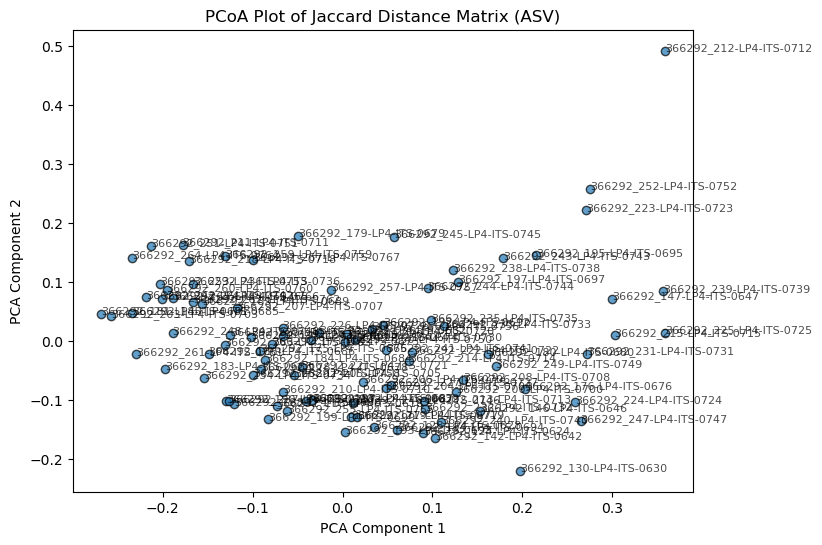

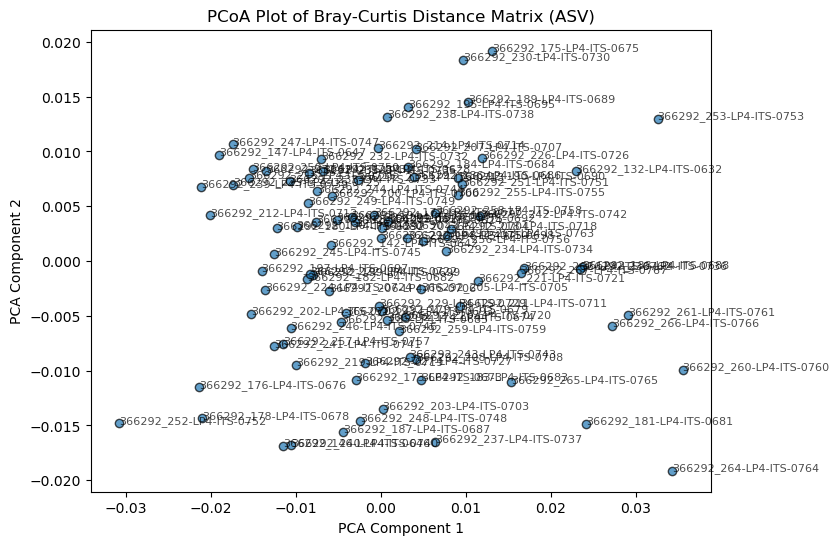

In [38]:
import matplotlib.pyplot as plt

# Function to plot PCA results
def plot_pca(pca_df, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_df.iloc[:, 0], pca_df.iloc[:, 1], alpha=0.7, edgecolors="black")

    # Annotate points with sample IDs
    for i, txt in enumerate(pca_df.index):
        plt.annotate(txt, (pca_df.iloc[i, 0], pca_df.iloc[i, 1]), fontsize=8, alpha=0.7)

    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(title)
    plt.show()

# Example: Plot PCA for Jaccard LP5
plot_pca(pcoa_jaccard_ASV, "PCoA Plot of Jaccard Distance Matrix (ASV)")

# Example: Plot PCA for Bray-Curtis LP5
plot_pca(pcoa_bray_curtis_ASV, "PCoA Plot of Bray-Curtis Distance Matrix (ASV)")

-->> looks about right

In [39]:
def align_pcoa_matrices(pcoa1, pcoa2):
    """
    Aligns two PCoA DataFrames by keeping only shared samples.
    Returns aligned DataFrames and lists of missing samples.
    """
    common_samples = pcoa1.index.intersection(pcoa2.index)
    
    missing_in_pcoa1 = pcoa2.index.difference(pcoa1.index)
    missing_in_pcoa2 = pcoa1.index.difference(pcoa2.index)
    
    print(f"Shared Samples: {len(common_samples)}")
    print(f"Samples missing in first PCoA: {len(missing_in_pcoa1)}")
    print(f"Samples missing in second PCoA: {len(missing_in_pcoa2)}")
    
    return pcoa1.loc[common_samples], pcoa2.loc[common_samples], missing_in_pcoa1, missing_in_pcoa2

# Align PCoAs before Procrustes
#bray_curtis pcoa:

pcoa_bray_ASV_ASVmerge_align, pcoa_bray_ASVmerge_ASV_align, missing_bray_ASV_ASVmerge, missing_bray_ASVmerge_ASV = align_pcoa_matrices(pcoa_bray_curtis_ASV, pcoa_bray_curtis_ASV_merged)
pcoa_bray_OTU_OTUmerge_align, pcoa_bray_OTUmerge_OTU_align, missing_bray_OTU_OTUmerge, missing_bray_OTUmerge_OTU = align_pcoa_matrices(pcoa_bray_curtis_OTU, pcoa_bray_curtis_OTU_merged)

pcoa_jaccard_ASV_ASVmerge_align, pcoa_jaccard_ASVmerge_ASV_align, missing_jaccard_ASV_ASVmerge, missing_jaccard_ASVmerge_ASV = align_pcoa_matrices(pcoa_jaccard_ASV, pcoa_jaccard_ASV_merged)
pcoa_jaccard_OTU_OTUmerge_align, pcoa_jaccard_OTUmerge_OTU_align, missing_jaccard_OTU_OTUmerge, missing_jaccard_OTUmerge_OTU = align_pcoa_matrices(pcoa_jaccard_OTU, pcoa_jaccard_OTU_merged)


pcoa_jaccard_OTU_ASV_align, pcoa_jaccard_ASV_OTU_align, missing_jaccard_OTU_ASV, missing_jaccard_ASV_OTU = align_pcoa_matrices(pcoa_jaccard_OTU_merged, pcoa_jaccard_ASV_merged)
pcoa_bray_OTU_ASV_align, pcoa_bray_ASV_OTU_align, missing_bray_OTU_ASV, missing_bray_ASV_OTU = align_pcoa_matrices(pcoa_bray_curtis_OTU_merged, pcoa_bray_curtis_ASV_merged)

Shared Samples: 95
Samples missing in first PCoA: 4
Samples missing in second PCoA: 0
Shared Samples: 95
Samples missing in first PCoA: 4
Samples missing in second PCoA: 0
Shared Samples: 95
Samples missing in first PCoA: 4
Samples missing in second PCoA: 0
Shared Samples: 95
Samples missing in first PCoA: 4
Samples missing in second PCoA: 0
Shared Samples: 99
Samples missing in first PCoA: 0
Samples missing in second PCoA: 0
Shared Samples: 99
Samples missing in first PCoA: 0
Samples missing in second PCoA: 0


In [40]:
from scipy.spatial import procrustes
import pandas as pd

def perform_procrustes(pcoa1, pcoa2):
    """
    Runs Procrustes analysis on aligned PCoA results and returns transformed coordinates + disparity.
    Ensures matrices are standardized before comparison.
    """
    # Convert DataFrames to numpy arrays
    mtx1, mtx2, disparity = procrustes(pcoa1.values, pcoa2.values)
    
    # Convert back to DataFrames, preserving original index and column names
    return pd.DataFrame(mtx1, index=pcoa1.index, columns=pcoa1.columns), \
           pd.DataFrame(mtx2, index=pcoa2.index, columns=pcoa2.columns), disparity

# Bray–Curtis: ASV vs ASV_merged
pcoa_bray_ASV_ASVmerge_trans, pcoa_bray_ASVmerge_ASV_trans, disparity_bray_asv = perform_procrustes(
    pcoa_bray_ASV_ASVmerge_align, pcoa_bray_ASVmerge_ASV_align)

# Bray–Curtis: OTU vs OTU_merged
pcoa_bray_OTU_OTUmerge_trans, pcoa_bray_OTUmerge_OTU_trans, disparity_bray_otu = perform_procrustes(
    pcoa_bray_OTU_OTUmerge_align, pcoa_bray_OTUmerge_OTU_align)

# Jaccard: ASV vs ASV_merged
pcoa_jaccard_ASV_ASVmerge_trans, pcoa_jaccard_ASVmerge_ASV_trans, disparity_jaccard_asv = perform_procrustes(
    pcoa_jaccard_ASV_ASVmerge_align, pcoa_jaccard_ASVmerge_ASV_align)

# Jaccard: OTU vs OTU_merged
pcoa_jaccard_OTU_OTUmerge_trans, pcoa_jaccard_OTUmerge_OTU_trans, disparity_jaccard_otu = perform_procrustes(
    pcoa_jaccard_OTU_OTUmerge_align, pcoa_jaccard_OTUmerge_OTU_align)

# Cross-comparison: OTU_merged vs ASV_merged — Jaccard
pcoa_jaccard_OTU_ASV_trans, pcoa_jaccard_ASV_OTU_trans, disparity_jaccard_cross = perform_procrustes(
    pcoa_jaccard_OTU_ASV_align, pcoa_jaccard_ASV_OTU_align)

# Cross-comparison: OTU_merged vs ASV_merged — Bray–Curtis
pcoa_bray_OTU_ASV_trans, pcoa_bray_ASV_OTU_trans, disparity_bray_cross = perform_procrustes(
    pcoa_bray_OTU_ASV_align, pcoa_bray_ASV_OTU_align)




# Print results
# Print results
print(f"Procrustes Disparity - Bray Curtis PCoA ASV vs ASV-merge: {disparity_bray_asv:.4f}")
print(f"Procrustes Disparity - Bray Curtis PCoA OTU vs OTU-merge: {disparity_bray_otu:.4f}")
print(f"Procrustes Disparity - Jaccard PCoA ASV vs ASV-merge: {disparity_jaccard_asv:.4f}")

print(f"Procrustes Disparity - Jaccard PCoA OTU vs OTU-merge: {disparity_jaccard_otu:.4f}")
print(f"Procrustes Disparity - Bray Curtis PCoA ASV-OTU: {disparity_bray_cross:.4f}")
print(f"Procrustes Disparity - Jaccard PCoA ASV-OTU: {disparity_jaccard_cross:.4f}")

Procrustes Disparity - Bray Curtis PCoA ASV vs ASV-merge: 0.5972
Procrustes Disparity - Bray Curtis PCoA OTU vs OTU-merge: 0.3481
Procrustes Disparity - Jaccard PCoA ASV vs ASV-merge: 0.0232
Procrustes Disparity - Jaccard PCoA OTU vs OTU-merge: 0.0134
Procrustes Disparity - Bray Curtis PCoA ASV-OTU: 0.0028
Procrustes Disparity - Jaccard PCoA ASV-OTU: 0.3834


In [41]:
import numpy as np
from scipy.spatial import procrustes

# Function for Procrustes permutation test
def procrustes_permutation_test(pcoa1, pcoa2, num_permutations=1000):
    """
    Computes Procrustes disparity and runs a permutation test to assess significance.
    Ensures matrices are correctly aligned and standardized before comparison.
    """

    # Convert DataFrames to numpy arrays
    mtx1, mtx2, observed_disparity = procrustes(pcoa1.values, pcoa2.values)
    
    # Generate null distribution by shuffling rows of pcoa2
    permuted_disparities = []
    for _ in range(num_permutations):
        shuffled = pcoa2.sample(frac=1, replace=False).reset_index(drop=True)  # Shuffle row order
        _, _, perm_disparity = procrustes(mtx1, shuffled.values)  # Compare against shuffled matrix
        permuted_disparities.append(perm_disparity)
    
    # Compute p-value as the proportion of permuted disparities ≤ observed disparity
    p_value = np.sum(np.array(permuted_disparities) <= observed_disparity) / num_permutations

    return observed_disparity, np.percentile(permuted_disparities, [2.5, 97.5]), p_value

In [42]:
# Run tests for all PCoA comparisons
#adapt for those ones:
#bray_curtis pcoa:


pcoa_tests = {
    "Bray–Curtis PCoA ASV vs ASV_merged": (
        pcoa_bray_ASV_ASVmerge_trans, pcoa_bray_ASVmerge_ASV_trans),

    "Bray–Curtis PCoA OTU vs OTU_merged": (
        pcoa_bray_OTU_OTUmerge_trans, pcoa_bray_OTUmerge_OTU_trans),

    "Jaccard PCoA ASV vs ASV_merged": (
        pcoa_jaccard_ASV_ASVmerge_trans, pcoa_jaccard_ASVmerge_ASV_trans),

    "Jaccard PCoA OTU vs OTU_merged": (
        pcoa_jaccard_OTU_OTUmerge_trans, pcoa_jaccard_OTUmerge_OTU_trans),

    "Bray–Curtis PCoA ASV_merged vs OTU_merged": (
        pcoa_bray_OTU_ASV_trans, pcoa_bray_ASV_OTU_trans),

    "Jaccard PCoA ASV_merged vs OTU_merged": (
        pcoa_jaccard_OTU_ASV_trans, pcoa_jaccard_ASV_OTU_trans),
}


# Store results
pcoa_results = {}

for name, (pcoa1, pcoa2) in pcoa_tests.items():
    obs_disp, conf_int, p_val = procrustes_permutation_test(pcoa1, pcoa2)
    pcoa_results[name] = {"Observed Disparity": obs_disp, "95% CI": conf_int, "P-value": p_val}

# Convert to DataFrame
import pandas as pd
pcoa_results_df = pd.DataFrame.from_dict(pcoa_results, orient="index")

# Display results
pcoa_results_df

Observed Disparity  \
Bray–Curtis PCoA ASV vs ASV_merged                   0.597223   
Bray–Curtis PCoA OTU vs OTU_merged                   0.348149   
Jaccard PCoA ASV vs ASV_merged                       0.023173   
Jaccard PCoA OTU vs OTU_merged                       0.013421   
Bray–Curtis PCoA ASV_merged vs OTU_merged            0.002767   
Jaccard PCoA ASV_merged vs OTU_merged                0.383363   

                                                                             95% CI  \
Bray–Curtis PCoA ASV vs ASV_merged         [0.9579545943898582, 0.9985262563207211]   
Bray–Curtis PCoA OTU vs OTU_merged         [0.9537623962685902, 0.9991209544597066]   
Jaccard PCoA ASV vs ASV_merged             [0.9544387777435391, 0.9981214063587547]   
Jaccard PCoA OTU vs OTU_merged             [0.9507368335139588, 0.9984925942909828]   
Bray–Curtis PCoA ASV_merged vs OTU_merged  [0.9298798639011353, 0.9996936301111272]   
Jaccard PCoA ASV_merged vs OTU_merged      [0.9571422919709679, 0.9985259564883188]   

                                           P-value  
Bray–Curtis PCoA ASV vs ASV_merged             0.0  
Bray–Curtis PCoA OTU vs OTU_merged             0.0  
Jaccard PCoA ASV vs ASV_merged                 0.0  
Jaccard PCoA OTU vs OTU_merged                 0.0  
Bray–Curtis PCoA ASV_merged vs OTU_merged      0.0  
Jaccard PCoA ASV_merged vs OTU_merged          0.0

In [43]:
hex_colors = [
    "#345084FF", "#CB6BCEFF", "#468892FF", "#74F3D3FF",
    "#751C6DFF", "#FDC067FF", "#AC9ECEFF", "#6EC5ABFF"
]

/scratch/meyeanni/tmp/ipykernel_2344834/3500430472.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pval = disparity_df["P-value"][comp_nr]
/scratch/meyeanni/tmp/ipykernel_2344834/3500430472.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend(title=f"M²: {disparity_df['Observed Disparity'][comp_nr]:.4f} | p-value: <0.001", fontsize=12, title_fontsize=12)


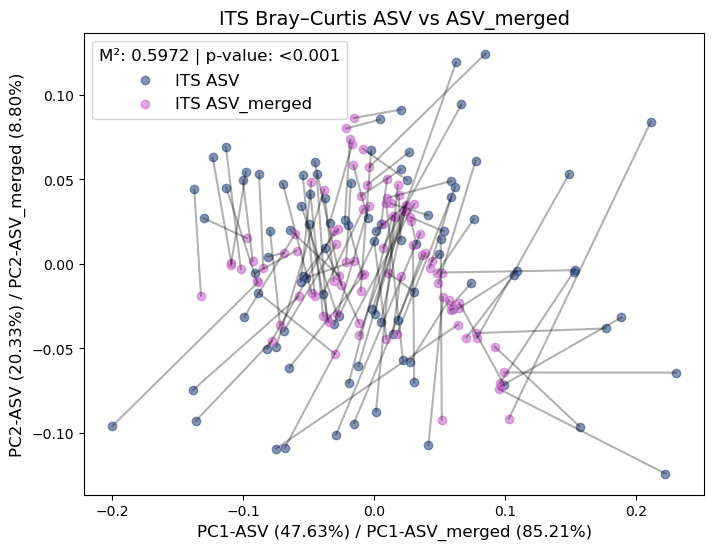

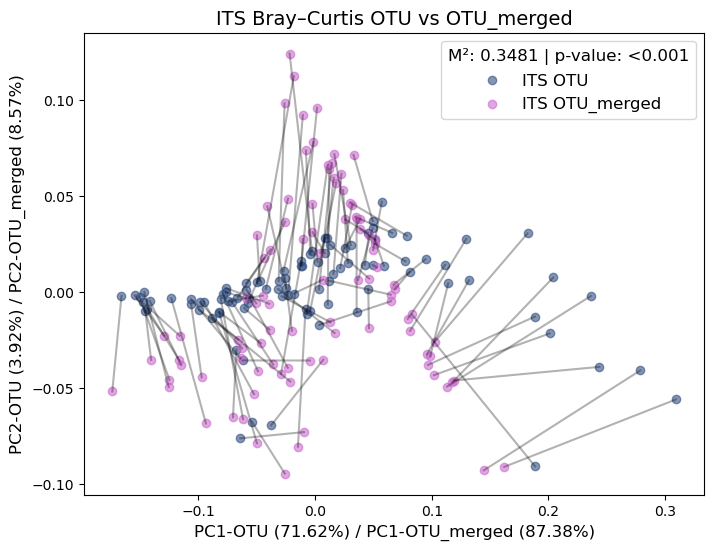

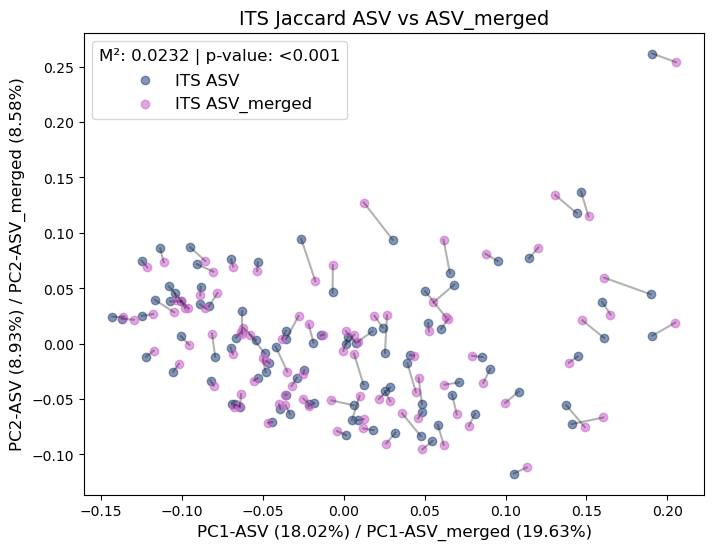

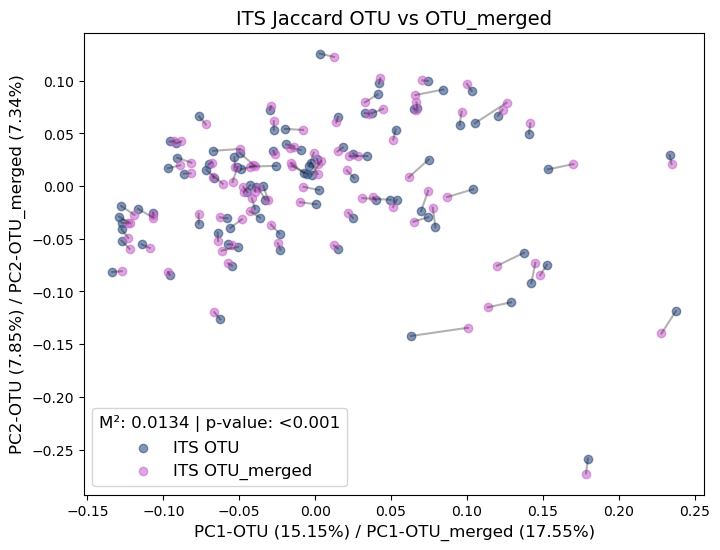

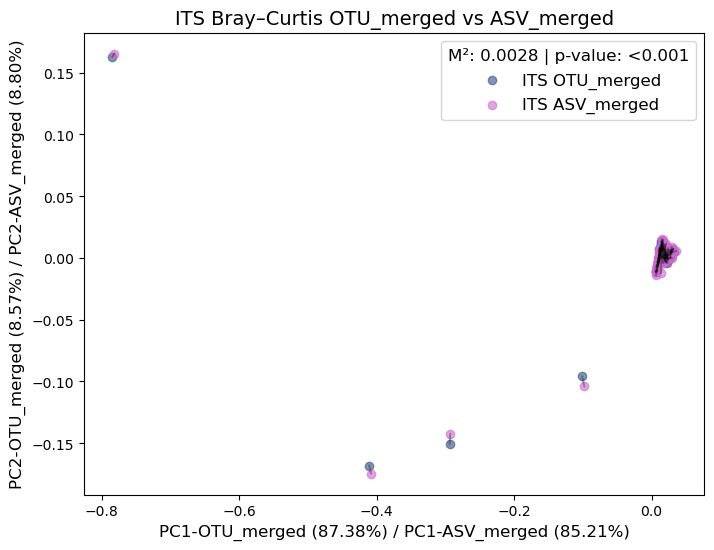

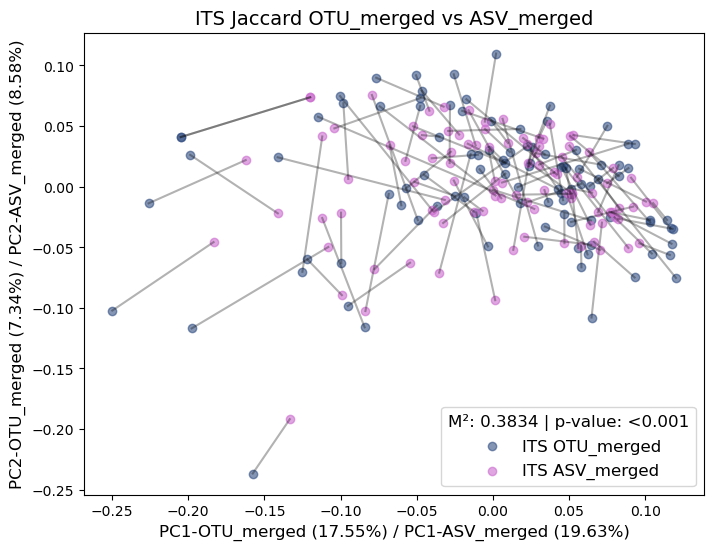

In [44]:
import matplotlib.pyplot as plt

def plot_procrustes(pcoa1, pcoa2, title, var1, var2, disparity_df, comp_nr, approach1, approach2):
    """Plots Procrustes-transformed PCoA results with connections between corresponding samples."""
    plt.figure(figsize=(8, 6))

    plt.scatter(pcoa1["PCo1"], pcoa1["PCo2"], color="#345084FF", label=f"ITS {approach1}", alpha=0.6)
    plt.scatter(pcoa2["PCo1"], pcoa2["PCo2"], color="#CB6BCEFF", label=f"ITS {approach2}", alpha=0.6)
    
    for i in range(len(pcoa1)):
        plt.plot([pcoa1.iloc[i, 0], pcoa2.iloc[i, 0]], 
                 [pcoa1.iloc[i, 1], pcoa2.iloc[i, 1]], "k-", alpha=0.3)
    var1 = var1 *100
    var2 = var2 *100
    plt.xlabel(f"PC1-{approach1} ({var1[0]:.2f}%) / PC1-{approach2} ({var2[0]:.2f}%)", fontsize=12)
    plt.ylabel(f"PC2-{approach1} ({var1[1]:.2f}%) / PC2-{approach2} ({var2[1]:.2f}%)", fontsize=12)

    #add a legend including also the observed disparity and p-value:
    pval = disparity_df["P-value"][comp_nr]
    if pval < 0.001:
        plt.legend(title=f"M²: {disparity_df['Observed Disparity'][comp_nr]:.4f} | p-value: <0.001", fontsize=12, title_fontsize=12)
    else:
        plt.legend(title=f"M²: {disparity_df['Observed Disparity'][comp_nr]:.4f} | p-value: {disparity_df['P-value'][comp_nr]:.3f}", fontsize=12, title_fontsize=12)
    #plt.legend(title=f"M2: {disparity_df['Observed Disparity'][comp_nr]:.4f} | p-value: {disparity_df['P-value'][comp_nr]:.4f}")
    plt.title(title, fontsize=14)
    plt.show()


# Plot Procrustes alignments

#put it those variances:

# Bray–Curtis: ASV vs ASV_merged
plot_procrustes(
    pcoa_bray_ASV_ASVmerge_trans, pcoa_bray_ASVmerge_ASV_trans,
    "ITS Bray–Curtis ASV vs ASV_merged",
    variance_bray_curtis_ASV, variance_bray_curtis_ASV_merged,
    pcoa_results_df, comp_nr=0,
    approach1="ASV", approach2="ASV_merged"
)

# Bray–Curtis: OTU vs OTU_merged
plot_procrustes(
    pcoa_bray_OTU_OTUmerge_trans, pcoa_bray_OTUmerge_OTU_trans,
    "ITS Bray–Curtis OTU vs OTU_merged",
    variance_bray_curtis_OTU, variance_bray_curtis_OTU_merged,
    pcoa_results_df, comp_nr=1,
    approach1="OTU", approach2="OTU_merged"
)

# Jaccard: ASV vs ASV_merged
plot_procrustes(
    pcoa_jaccard_ASV_ASVmerge_trans, pcoa_jaccard_ASVmerge_ASV_trans,
    "ITS Jaccard ASV vs ASV_merged",
    variance_jaccard_ASV, variance_jaccard_ASV_merged,
    pcoa_results_df, comp_nr=2,
    approach1="ASV", approach2="ASV_merged"
)

# Jaccard: OTU vs OTU_merged
plot_procrustes(
    pcoa_jaccard_OTU_OTUmerge_trans, pcoa_jaccard_OTUmerge_OTU_trans,
    "ITS Jaccard OTU vs OTU_merged",
    variance_jaccard_OTU, variance_jaccard_OTU_merged,
    pcoa_results_df, comp_nr=3,
    approach1="OTU", approach2="OTU_merged"
)

# Bray–Curtis: ASV_merged vs OTU_merged
plot_procrustes(
    pcoa_bray_OTU_ASV_trans, pcoa_bray_ASV_OTU_trans,
    "ITS Bray–Curtis OTU_merged vs ASV_merged",
    variance_bray_curtis_OTU_merged, variance_bray_curtis_ASV_merged,
    pcoa_results_df, comp_nr=4,
    approach1="OTU_merged", approach2="ASV_merged"
)

# Jaccard: ASV_merged vs OTU_merged
plot_procrustes(
    pcoa_jaccard_OTU_ASV_trans, pcoa_jaccard_ASV_OTU_trans,
    "ITS Jaccard OTU_merged vs ASV_merged",
    variance_jaccard_OTU_merged, variance_jaccard_ASV_merged,
    pcoa_results_df, comp_nr=5,
    approach1="OTU_merged", approach2="ASV_merged"
)


In [45]:
metadata_ITS

label_barcode1 label_barcode2      created_date  \
SampleID                                                                  
366292_209-LP4-ITS-0709   ACCCGAGGCCTC   CAAATGGTCGTC  16.10.2024 14:59   
366292_255-LP4-ITS-0755   AGGGCGAAGAAG   AATATCGGGATC  16.10.2024 14:59   
366292_237-LP4-ITS-0737   GTCCCGTCGGGT   GTCAATTAGTGG  16.10.2024 14:59   
366292_198-LP4-ITS-0698   TGGACTTACCAG   TTGCGACAAAGT  16.10.2024 14:59   
366292_240-LP4-ITS-0740   CGCCTCCTATGG   AGAAGGCCTTAT  16.10.2024 14:59   
...                                ...            ...               ...   
366292_231-LP4-ITS-0731   AGGGCGAAGAAG   GGCCTATAAGTC  16.10.2024 14:59   
366292_245-LP4-ITS-0745   GTCCCGTCGGGT   CCTAAGAGCATC  16.10.2024 14:59   
366292_252-LP4-ITS-0752   TATTGAATATTG   TAGTGTCGGATC  16.10.2024 14:59   
366292_212-LP4-ITS-0712   TATTGAATATTG   GGCAGTGTTAAT  16.10.2024 14:59   
366292_128-LP4-ITS-0628   AGACCGTCAGAC   CGCGGCGCAGCT  16.10.2024 14:59   

                        amplicon     unique_id  sample_id plate  \
SampleID                                                          
366292_209-LP4-ITS-0709      ITS  LP4-ITS-0709  W00.00.00    P8   
366292_255-LP4-ITS-0755      ITS  LP4-ITS-0755  W04.01.01    P8   
366292_237-LP4-ITS-0737      ITS  LP4-ITS-0737  W04.01.02    P8   
366292_198-LP4-ITS-0698      ITS  LP4-ITS-0698  W04.01.03    P8   
366292_240-LP4-ITS-0740      ITS  LP4-ITS-0740  W04.01.04    P8   
...                          ...           ...        ...   ...   
366292_231-LP4-ITS-0731      ITS  LP4-ITS-0731  W30.03.06    P8   
366292_245-LP4-ITS-0745      ITS  LP4-ITS-0745  W30.03.10    P8   
366292_252-LP4-ITS-0752      ITS  LP4-ITS-0752  W30.03.14    P8   
366292_212-LP4-ITS-0712      ITS  LP4-ITS-0712  W30.03.21    P8   
366292_128-LP4-ITS-0628      ITS  LP4-ITS-0628  W30.03.28    P7   

                        plate_position  amplicon_conc DNA_extraction_plate  \
SampleID                                                                     
366292_209-LP4-ITS-0709            E05       1.184620                DNA74   
366292_255-LP4-ITS-0755            C11      18.154860                DNA74   
366292_237-LP4-ITS-0737            A09       5.543120                DNA74   
366292_198-LP4-ITS-0698            B04      14.986790                DNA74   
366292_240-LP4-ITS-0740            D09      15.458240                DNA74   
...                                ...            ...                  ...   
366292_231-LP4-ITS-0731            C08      16.604110                DNA74   
366292_245-LP4-ITS-0745            A10      10.094150                DNA74   
366292_252-LP4-ITS-0752            H10      24.542690                DNA74   
366292_212-LP4-ITS-0712            H05      16.688820                DNA74   
366292_128-LP4-ITS-0628            D07       0.854114                DNA61   

                          project sample_type  day  temperature  hand  \
SampleID                                                                
366292_209-LP4-ITS-0709  shipping   sourdough    0           20   NaN   
366292_255-LP4-ITS-0755  shipping   sourdough    1            4   NaN   
366292_237-LP4-ITS-0737  shipping   sourdough    2            4   NaN   
366292_198-LP4-ITS-0698  shipping   sourdough    3            4   NaN   
366292_240-LP4-ITS-0740  shipping   sourdough    4            4   NaN   
...                           ...         ...  ...          ...   ...   
366292_231-LP4-ITS-0731  shipping   sourdough    6           30   NaN   
366292_245-LP4-ITS-0745  shipping   sourdough   10           30   NaN   
366292_252-LP4-ITS-0752  shipping   sourdough   14           30   NaN   
366292_212-LP4-ITS-0712  shipping   sourdough   21           30   NaN   
366292_128-LP4-ITS-0628  shipping   sourdough   28           30   NaN   

                        decontam_1 decontam_2  UniqueFeaturesCount  \
SampleID                                                             
366292_209-LP4-ITS-0709     sample     sample                    8   
3

In [46]:
metadata = metadata_ITS.copy()

In [47]:
metadata

label_barcode1 label_barcode2      created_date  \
SampleID                                                                  
366292_209-LP4-ITS-0709   ACCCGAGGCCTC   CAAATGGTCGTC  16.10.2024 14:59   
366292_255-LP4-ITS-0755   AGGGCGAAGAAG   AATATCGGGATC  16.10.2024 14:59   
366292_237-LP4-ITS-0737   GTCCCGTCGGGT   GTCAATTAGTGG  16.10.2024 14:59   
366292_198-LP4-ITS-0698   TGGACTTACCAG   TTGCGACAAAGT  16.10.2024 14:59   
366292_240-LP4-ITS-0740   CGCCTCCTATGG   AGAAGGCCTTAT  16.10.2024 14:59   
...                                ...            ...               ...   
366292_231-LP4-ITS-0731   AGGGCGAAGAAG   GGCCTATAAGTC  16.10.2024 14:59   
366292_245-LP4-ITS-0745   GTCCCGTCGGGT   CCTAAGAGCATC  16.10.2024 14:59   
366292_252-LP4-ITS-0752   TATTGAATATTG   TAGTGTCGGATC  16.10.2024 14:59   
366292_212-LP4-ITS-0712   TATTGAATATTG   GGCAGTGTTAAT  16.10.2024 14:59   
366292_128-LP4-ITS-0628   AGACCGTCAGAC   CGCGGCGCAGCT  16.10.2024 14:59   

                        amplicon     unique_id  sample_id plate  \
SampleID                                                          
366292_209-LP4-ITS-0709      ITS  LP4-ITS-0709  W00.00.00    P8   
366292_255-LP4-ITS-0755      ITS  LP4-ITS-0755  W04.01.01    P8   
366292_237-LP4-ITS-0737      ITS  LP4-ITS-0737  W04.01.02    P8   
366292_198-LP4-ITS-0698      ITS  LP4-ITS-0698  W04.01.03    P8   
366292_240-LP4-ITS-0740      ITS  LP4-ITS-0740  W04.01.04    P8   
...                          ...           ...        ...   ...   
366292_231-LP4-ITS-0731      ITS  LP4-ITS-0731  W30.03.06    P8   
366292_245-LP4-ITS-0745      ITS  LP4-ITS-0745  W30.03.10    P8   
366292_252-LP4-ITS-0752      ITS  LP4-ITS-0752  W30.03.14    P8   
366292_212-LP4-ITS-0712      ITS  LP4-ITS-0712  W30.03.21    P8   
366292_128-LP4-ITS-0628      ITS  LP4-ITS-0628  W30.03.28    P7   

                        plate_position  amplicon_conc DNA_extraction_plate  \
SampleID                                                                     
366292_209-LP4-ITS-0709            E05       1.184620                DNA74   
366292_255-LP4-ITS-0755            C11      18.154860                DNA74   
366292_237-LP4-ITS-0737            A09       5.543120                DNA74   
366292_198-LP4-ITS-0698            B04      14.986790                DNA74   
366292_240-LP4-ITS-0740            D09      15.458240                DNA74   
...                                ...            ...                  ...   
366292_231-LP4-ITS-0731            C08      16.604110                DNA74   
366292_245-LP4-ITS-0745            A10      10.094150                DNA74   
366292_252-LP4-ITS-0752            H10      24.542690                DNA74   
366292_212-LP4-ITS-0712            H05      16.688820                DNA74   
366292_128-LP4-ITS-0628            D07       0.854114                DNA61   

                          project sample_type  day  temperature  hand  \
SampleID                                                                
366292_209-LP4-ITS-0709  shipping   sourdough    0           20   NaN   
366292_255-LP4-ITS-0755  shipping   sourdough    1            4   NaN   
366292_237-LP4-ITS-0737  shipping   sourdough    2            4   NaN   
366292_198-LP4-ITS-0698  shipping   sourdough    3            4   NaN   
366292_240-LP4-ITS-0740  shipping   sourdough    4            4   NaN   
...                           ...         ...  ...          ...   ...   
366292_231-LP4-ITS-0731  shipping   sourdough    6           30   NaN   
366292_245-LP4-ITS-0745  shipping   sourdough   10           30   NaN   
366292_252-LP4-ITS-0752  shipping   sourdough   14           30   NaN   
366292_212-LP4-ITS-0712  shipping   sourdough   21           30   NaN   
366292_128-LP4-ITS-0628  shipping   sourdough   28           30   NaN   

                        decontam_1 decontam_2  UniqueFeaturesCount  \
SampleID                                                             
366292_209-LP4-ITS-0709     sample     sample                    8   
3

In [48]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_procrustes(pcoa1, pcoa2, title, var1, var2, disparity_df, comp_nr, approach1, approach2, metadata):
    """Plots Procrustes-transformed PCoA results with connections between corresponding samples,
       colored by fermentation temperature (same base color, lighter for approach1, darker for approach2).
    """
    temperatures = metadata.loc[pcoa1.index, "temperature"]  # numeric variable
    
    # Normalize temperature range for consistent colormap mapping
    norm = mcolors.Normalize(vmin=temperatures.min(), vmax=temperatures.max())
    cmap = cm.viridis  # or any other perceptually uniform colormap

    # Color mapping for each sample
    colors1 = [mcolors.to_hex(cmap(norm(temp), alpha=0.5)) for temp in temperatures]  # lighter
    colors2 = [mcolors.to_hex(cmap(norm(temp), alpha=1.0)) for temp in temperatures]  # darker

    fig, ax = plt.subplots(figsize=(8, 6))

    # Scatter plots
    sc1 = ax.scatter(pcoa1["PCo1"], pcoa1["PCo2"], c=colors1, edgecolors="k", label=f"{approach1} (lighter)", alpha=0.6)
    sc2 = ax.scatter(pcoa2["PCo1"], pcoa2["PCo2"], c=colors2, edgecolors="k", label=f"{approach2} (darker)", alpha=0.9)

    # Connecting lines
    for i in range(len(pcoa1)):
        ax.plot([pcoa1.iloc[i, 0], pcoa2.iloc[i, 0]],
                [pcoa1.iloc[i, 1], pcoa2.iloc[i, 1]], "k-", alpha=0.3)

    # Axis labels
    ax.set_xlabel(f"PC1-{approach1} ({var1[0]:.2f}%) / PC1-{approach2} ({var2[0]:.2f}%)", fontsize=12)
    ax.set_ylabel(f"PC2-{approach1} ({var1[1]:.2f}%) / PC2-{approach2} ({var2[1]:.2f}%)", fontsize=12)

    # Title
    ax.set_title(title, fontsize=14)

    # Colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, label="Fermentation temperature (°C)")

    # Procrustes legend (outside)
    pval = disparity_df["P-value"][comp_nr]
    disparity = disparity_df["Observed Disparity"][comp_nr]
    legend_title = f"M²: {disparity:.4f} | p-value: <0.001" if pval < 0.001 else f"M²: {disparity:.4f} | p-value: {pval:.3f}"

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=legend_title, fontsize=12, title_fontsize=12)

    fig.tight_layout()
    plt.show()



/scratch/meyeanni/tmp/ipykernel_2344834/3847255670.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pval = disparity_df["P-value"][comp_nr]
/scratch/meyeanni/tmp/ipykernel_2344834/3847255670.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  disparity = disparity_df["Observed Disparity"][comp_nr]


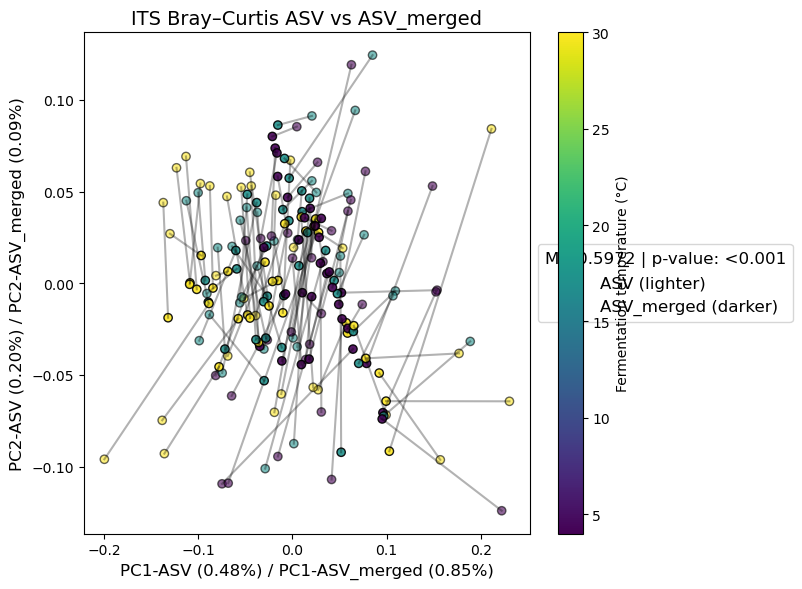

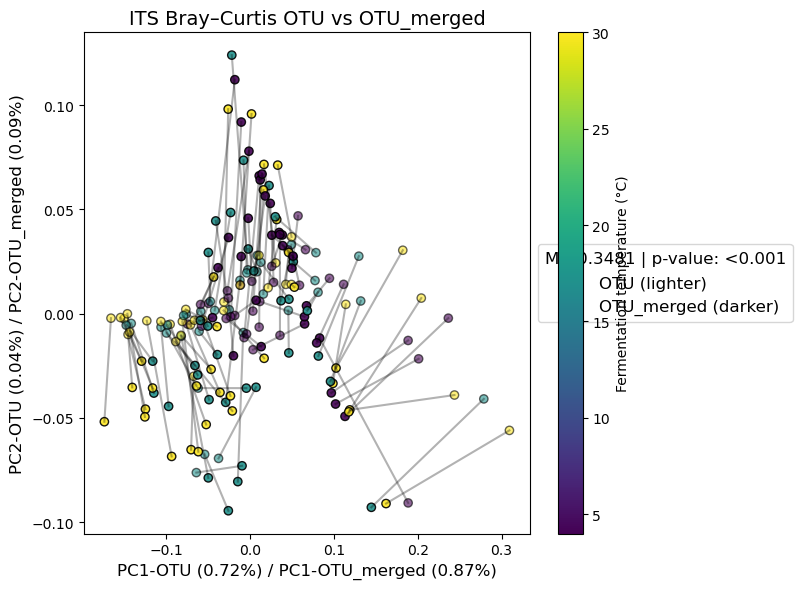

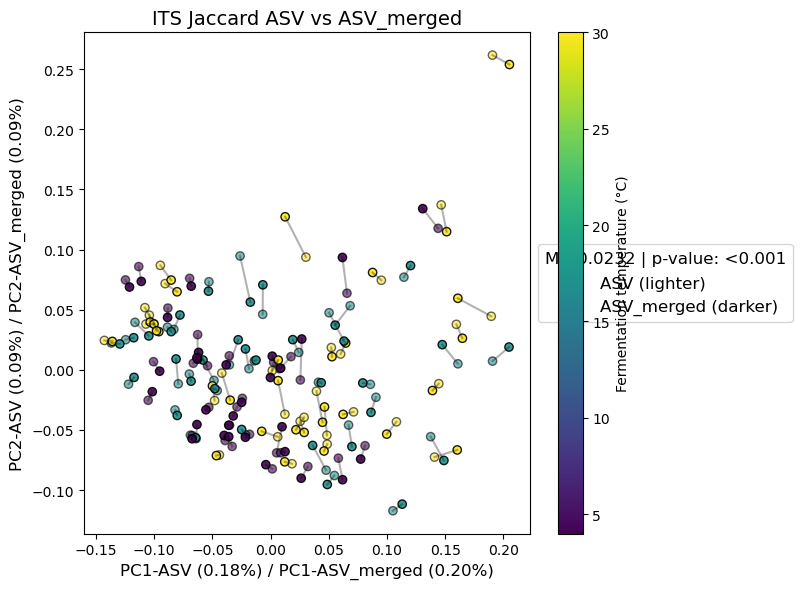

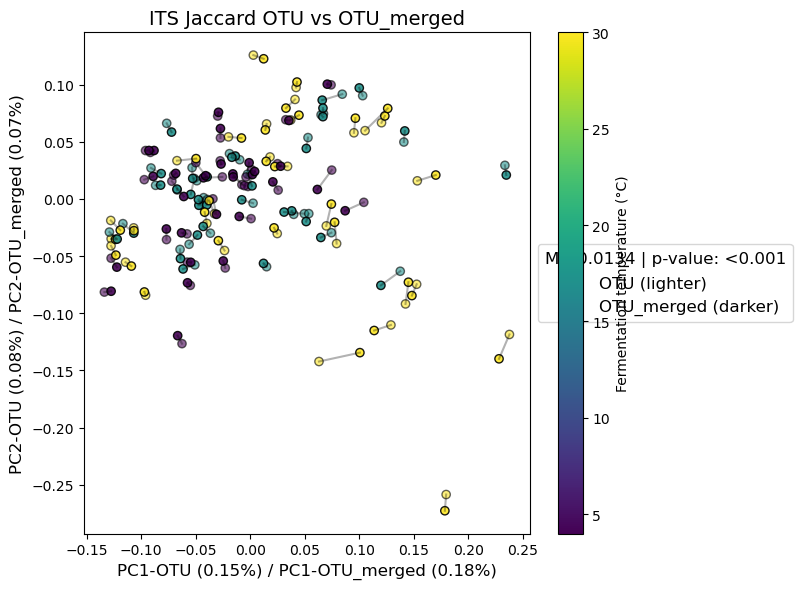

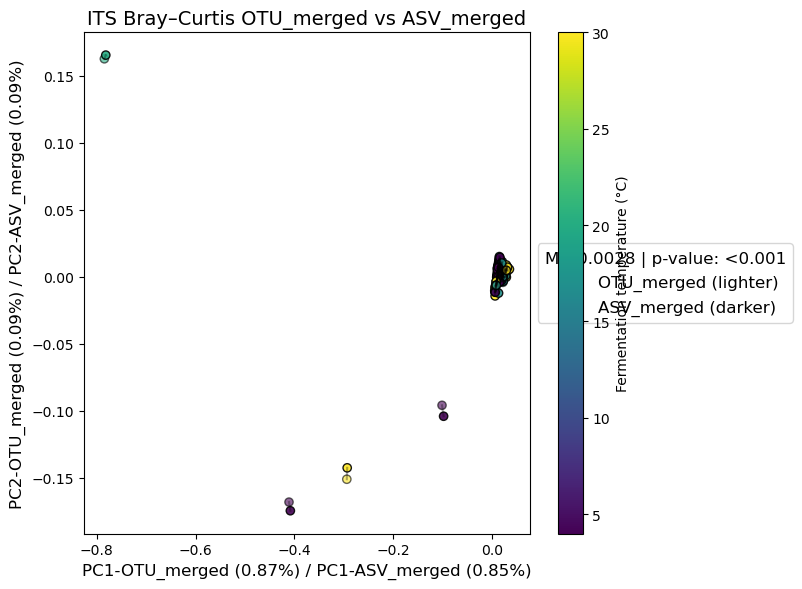

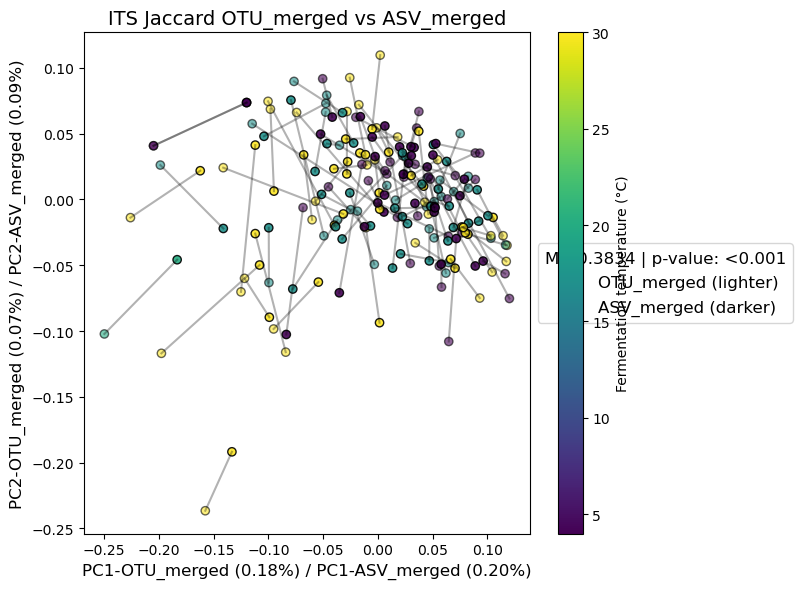

In [49]:
# Bray–Curtis: ASV vs ASV_merged
plot_procrustes(
    pcoa_bray_ASV_ASVmerge_trans, pcoa_bray_ASVmerge_ASV_trans,
    "ITS Bray–Curtis ASV vs ASV_merged",
    variance_bray_curtis_ASV, variance_bray_curtis_ASV_merged,
    pcoa_results_df, comp_nr=0,
    approach1="ASV", approach2="ASV_merged",
    metadata=metadata
)

# Bray–Curtis: OTU vs OTU_merged
plot_procrustes(
    pcoa_bray_OTU_OTUmerge_trans, pcoa_bray_OTUmerge_OTU_trans,
    "ITS Bray–Curtis OTU vs OTU_merged",
    variance_bray_curtis_OTU, variance_bray_curtis_OTU_merged,
    pcoa_results_df, comp_nr=1,
    approach1="OTU", approach2="OTU_merged",
    metadata=metadata
)

# Jaccard: ASV vs ASV_merged
plot_procrustes(
    pcoa_jaccard_ASV_ASVmerge_trans, pcoa_jaccard_ASVmerge_ASV_trans,
    "ITS Jaccard ASV vs ASV_merged",
    variance_jaccard_ASV, variance_jaccard_ASV_merged,
    pcoa_results_df, comp_nr=2,
    approach1="ASV", approach2="ASV_merged",
    metadata=metadata
)

# Jaccard: OTU vs OTU_merged
plot_procrustes(
    pcoa_jaccard_OTU_OTUmerge_trans, pcoa_jaccard_OTUmerge_OTU_trans,
    "ITS Jaccard OTU vs OTU_merged",
    variance_jaccard_OTU, variance_jaccard_OTU_merged,
    pcoa_results_df, comp_nr=3,
    approach1="OTU", approach2="OTU_merged",
    metadata=metadata
)

# Bray–Curtis: ASV_merged vs OTU_merged
plot_procrustes(
    pcoa_bray_OTU_ASV_trans, pcoa_bray_ASV_OTU_trans,
    "ITS Bray–Curtis OTU_merged vs ASV_merged",
    variance_bray_curtis_OTU_merged, variance_bray_curtis_ASV_merged,
    pcoa_results_df, comp_nr=4,
    approach1="OTU_merged", approach2="ASV_merged",
    metadata=metadata
)

# Jaccard: ASV_merged vs OTU_merged
plot_procrustes(
    pcoa_jaccard_OTU_ASV_trans, pcoa_jaccard_ASV_OTU_trans,
    "ITS Jaccard OTU_merged vs ASV_merged",
    variance_jaccard_OTU_merged, variance_jaccard_ASV_merged,
    pcoa_results_df, comp_nr=5,
    approach1="OTU_merged", approach2="ASV_merged",
    metadata=metadata
)


ok, that was a bit of a fail, will cluster based on time and temperature in a next script (both on merged and non-merged tables). but first, also ake annotated feature tables (species level)

available feature tables ITS:

- filtered_relative_frequency_table.qza
- filtered_table.qza

- merged_relative_frequency_table.qza
- merged_table.qza

-> make an annotated version for all of them!

have to make a taxa mapping for both OTUs and ASVs. first for OTUs (run through until saving the mapping file), then for ASVs (replace the artifact load for the taxonomy file, then rerun and save mapping file under another name)

In [66]:
#taxonomy_ITS = q2.Artifact.load("/home/meyeanni/cloud/meyeanni/LP5/artifacts/ITS/SILVA/silva-138.2-ssu-nr99-tax-515f-806r-derep-uniq.qza") #this is for OTUs

# taxonomy_ITS = q2.Artifact.load("/home/meyeanni/cloud/meyeanni/LP4/artifacts/ITS/sklearn/taxonomy_dada2.qza") #this is for ASVs
# # Convert taxonomy to DataFrame
# taxonomy_ITS_df = taxonomy_ITS.view(pd.DataFrame)
# taxonomy_ITS_df.head()
# # Split taxonomy column into separate levels
# taxonomy_ITS_df[['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']] = taxonomy_ITS_df['Taxon'].str.split(';', expand=True)

#taxonomy_ITS = q2.Artifact.load("/home/meyeanni/cloud/meyeanni/LP5/artifacts/ITS/UNITE/unite-10-99-all-euk-no-singletons-taxa-cleaned-derep.qza") ## this is for OTUs ITS
taxonomy_ITS = q2.Artifact.load("/home/meyeanni/cloud/meyeanni/LP4/artifacts/ITS/sklearn/taxonomy_dada1.qza") ## this is for ASVs ITS
# Convert taxonomy to DataFrame
taxonomy_ITS_df = taxonomy_ITS.view(pd.DataFrame)
taxonomy_ITS_df.head()
# Split taxonomy column into separate levels
taxonomy_ITS_df[['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Subspecies']] = taxonomy_ITS_df['Taxon'].str.split(';', expand=True)


In [20]:
# # Ensure Species column is stripped of whitespace
# taxonomy_ITS_df['Species'] = taxonomy_ITS_df['Species'].str.strip()

# # Debugging step: Check unique values in Species column
# print("Unique species before renaming:")
# print(taxonomy_ITS_df['Species'].unique())

# # Redefine the function to rename species
# def rename_species(row):
#     # Keywords indicating uncertainty or placeholder names
#     keywords = ['uncultured', 'metagenome', 'unidentified', 'bacterium_b4-c2-p2d8', 'unclassified']
    
#     # Check if the species name contains any keyword or is NaN
#     if pd.isna(row['Species']) or any(keyword in str(row['Species']).lower() for keyword in keywords):
#         # Replace species name with genus-based name
#         renamed = f"s__{row['Genus'].replace('g__', '').strip()}_sp."
#         print(f"Renaming '{row['Species']}' to '{renamed}' (genus-based)")  # Debugging output
        
#         # If the renamed species still results in "s__bacterium_sp."
#         if 'bacterium' in renamed.lower():
#             if pd.notna(row['Family']):
#                 # Replace with family-based name
#                 renamed = f"s__{row['Family'].replace('f__', '').strip()}_sp."
#                 print(f"Renaming genus-based '{renamed}' to family-based '{renamed}'")
        
#         return renamed
#     else:
#         # Keep the original species name
#         return row['Species']




# # Apply the renaming function across the DataFrame
# taxonomy_ITS_df['Species'] = taxonomy_ITS_df.apply(rename_species, axis=1)

# # Debugging: Check for remaining uncultured/metagenome entries
# remaining_uncultured = taxonomy_ITS_df[
#     taxonomy_ITS_df['Species'].str.contains('uncultured|metagenome|sedis', case=False, na=False)
# ]
# print("Remaining uncultured species after renaming:")
# print(remaining_uncultured)

# # Final unique species names after renaming
# print("Unique species after renaming:")
# print(taxonomy_ITS_df['Species'].unique())

Unique species before renaming:
['s__Triticum_urartu' 's__[Clostridium]_colinum' 's__Cupressus_chengiana'
 ... 's__uncultured_candidate_division_GN10_bacterium'
 's__Nanoarchaeota_archaeon_SCGC_AAA011-D5' 's__Euglenea']
Renaming 's__uncultured_bacterium' to 's__Incertae_Sedis_sp.' (genus-based)
Renaming 's__metagenome' to 's__Incertae_Sedis_sp.' (genus-based)
Renaming 's__metagenome' to 's__Incertae_Sedis_sp.' (genus-based)
Renaming 's__uncultured_bacterium' to 's__Incertae_Sedis_sp.' (genus-based)
Renaming 's__uncultured_bacterium' to 's__Incertae_Sedis_sp.' (genus-based)
Renaming 's__uncultured_bacterium' to 's__Incertae_Sedis_sp.' (genus-based)
Renaming 's__uncultured_bacterium' to 's__Incertae_Sedis_sp.' (genus-based)
Renaming 's__uncultured_sediment_bacterium' to 's__Incertae_Sedis_sp.' (genus-based)
Renaming 's__uncultured_forest_soil_bacterium' to 's__Acidicaldus_sp.' (genus-based)
Renaming 's__uncultured_bacterium' to 's__Faecalibacterium_sp.' (genus-based)
Renaming genus-based

only needed for ITS (separately)

In [67]:
# Ensure Species column is stripped of whitespace
taxonomy_ITS_df['Species'] = taxonomy_ITS_df['Species'].str.strip()

# Debugging step: Check unique values in Species column
print("Unique species before renaming:")
print(taxonomy_ITS_df['Species'].unique())

# Redefine the function to rename species
def rename_species(row):
    # Check if 'uncultured' or 'metagenome' appears in the species name
    if 'uncultured' in row['Species'].lower() or 'metagenome' in row['Species'].lower() or 'unidentified' in row['Species'].lower():
        # Replace species name with genus-based name
        renamed = f"s__{row['Genus'].replace('g__', '').strip()}_sp"
        print(f"Renaming '{row['Species']}' to '{renamed}'")  # Debugging output
        return renamed
    else:
        # Keep the original species name
        return row['Species']

# Apply the renaming function across the DataFrame
taxonomy_ITS_df['Species'] = taxonomy_ITS_df.apply(rename_species, axis=1)

# Debugging: Check for remaining uncultured/metagenome entries
remaining_uncultured = taxonomy_ITS_df[
    taxonomy_ITS_df['Species'].str.contains('uncultured|metagenome', case=False, na=False)
]
print("Remaining uncultured species after renaming:")
print(remaining_uncultured)

# Final unique species names after renaming
print("Unique species after renaming:")
print(taxonomy_ITS_df['Species'].unique())

Unique species before renaming:
['s__Rhizoplaca_novomexicana' 's__Pandora_formicae' 's__Haslea_sp' ...
 's__Candida_sorbosivorans' 's__Starmerella_etchellsii'
 's__Wickerhamomyces_pijperi']
Remaining uncultured species after renaming:
Empty DataFrame
Columns: [Taxon, Confidence, Kingdom, Phylum, Class, Order, Family, Genus, Species, Subspecies]
Index: []
Unique species after renaming:
['s__Rhizoplaca_novomexicana' 's__Pandora_formicae' 's__Haslea_sp' ...
 's__Candida_sorbosivorans' 's__Starmerella_etchellsii'
 's__Wickerhamomyces_pijperi']


In [68]:
# # Extract the first two words of the species name
# taxonomy_ITS_df["Species"] = (
#     taxonomy_ITS_df["Species"]
#     .str.replace("s__", "", regex=False)
#     .str.replace("_", " ", regex=False)
#     .fillna("Unclassified")
#     .str.extract(r'^(\S+(?:\s+\S+)?)')[0]  # Extract first one or two words
#     .fillna("Unclassified")  # Handle any NaNs after extraction
# )

taxonomy_ITS_df["Species"] = (
    taxonomy_ITS_df["Species"]
    .str.replace("s__", "", regex=False)
    .str.replace("_", " ", regex=False)
    .str.replace(" sp", " sp.", regex=False)
    .fillna("Unclassified")
    .str.extract(r'^(\S+(?:\s+\S+)?)')[0]  # Extract first one or two words
    .fillna("Unclassified")
)


# # Create mapping dictionaries from Feature ID to species
taxa_mapping_ITS_s = taxonomy_ITS_df["Species"].to_dict()
# taxa_mapping_ITS_s = taxonomy_ITS_df["Species"].to_dict()

In [53]:
pwd

'/home/meyeanni/cloud/meyeanni/LP4/artifacts/ITS/split_exp/shipping_v2'

In [5]:
#export the mapping files so in the future they can be reimported instead of running the code again:

import pickle

with open('taxa_mapping_ITS_s.pkl', 'wb') as f: ## this is for OTUs
    pickle.dump(taxa_mapping_ITS_s, f)

# with open('taxa_mapping_ITS_asv.pkl', 'wb') as f: ## this is for ASVs
#     pickle.dump(taxa_mapping_ITS_s, f)    

# with open('taxa_mapping_ITS_s.pkl', 'wb') as f:
#     pickle.dump(taxa_mapping_ITS_s, f)

#load the mapping files:
    


NameError: name 'taxa_mapping_ITS_s' is not defined

to reimport the mapping dictionary:

In [7]:
pwd

'/Users/meyeanni/Desktop/git_sourdough/SourdoughFlow/LP4/shipping_analysis/shipping_data'

In [8]:
import pickle

with open('ITS/taxa_mapping_ITS_s.pkl', 'rb') as f:
    taxa_mapping_ITS_s = pickle.load(f)


# with open('taxa_mapping_ITS_asv.pkl', 'rb') as f:
#     taxa_mapping_ITS_asv = pickle.load(f)    

# with open('taxa_mapping_ITS_s.pkl', 'rb') as f:
#     taxa_mapping_ITS_s = pickle.load(f)

In [71]:
taxa_mapping_ITS_asv

{'d8988d0c19e93a0f32b0aa471b74e452': 'Rhizoplaca novomexicana',
 '1bd2147eda3fbd7418a1c94885229e37': 'Pandora formicae',
 '4d4e61fed7e2249fb5b64514c00d86d9': 'Haslea sp.',
 '527ad00bae9e7c1c3848b6db6d319b77': 'Biomphalaria tenagophila',
 '9eba8141a523f5e62a5a6bca73ee62d9': 'Haslea sp.',
 '4040c071f067fa9875cc1d302168da58': 'Haslea sp.',
 '5ad918bf983be94bf59de663f9377155': 'Haslea sp.',
 'ccf8fd4db86c6fc676d8fcd2b985d920': 'Rhizoplaca novomexicana',
 '16d57e44cfcae04c843cd0184c7dba19': 'Haslea sp.',
 '2ed868465ac966f62ab733bed9f4c929': 'Haslea sp.',
 'b4d3793e06e428908db3d9893d3ad8a1': 'Limnanthes alba',
 '3869e72729c12d5249ce9ac24055bff1': 'Haslea sp.',
 '8c8b3dd34cc7f6805e99edef1820749d': 'Haslea sp.',
 '27283cda2c2f81fbc97dc3aac188f06f': 'Haslea sp.',
 '2ab0bf06953d50e67af80f287fb57a78': 'Biomphalaria tenagophila',
 '1fe7f45312804327a7d1adc0d4d1d998': 'Haslea sp.',
 'f968a7aed7e09e58790165ddbb915801': 'Limnanthes alba',
 '00fbd6ae53b1858cd0132de73bdacc25': 'Lessonia flavicans',
 'b9

- filtered_relative_frequency_table.qza
- filtered_table.qza

- merged_relative_frequency_table.qza
- merged_table.qza

In [11]:
pwd

'/home/meyeanni/cloud/meyeanni/LP4/artifacts/16S/split_exp/shipping_v2'

ASVs:

In [72]:
filtered_rel_tab_ASV = qiime2.Artifact.load('ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_relative_frequency_table.qza')
# Extract the data as a pandas DataFrame
filtered_rel_tab_ASV = filtered_rel_tab_ASV.view(pd.DataFrame)

filtered_tab_ASV = qiime2.Artifact.load('ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_table.qza')
# Extract the data as a pandas DataFrame
filtered_tab_ASV = filtered_tab_ASV.view(pd.DataFrame)

merged_rel_tab_ASV = qiime2.Artifact.load('ASVs/alpha_rarefaction/core-metrics-results-1000/merged_relative_frequency_table.qza')
# Extract the data as a pandas DataFrame
merged_rel_tab_ASV = merged_rel_tab_ASV.view(pd.DataFrame)

merged_tab_ASV = qiime2.Artifact.load('ASVs/alpha_rarefaction/core-metrics-results-1000/merged_table.qza')
# Extract the data as a pandas DataFrame
merged_tab_ASV = merged_tab_ASV.view(pd.DataFrame)

OTUs:

In [9]:
filtered_rel_tab_OTU = qiime2.Artifact.load('ITS/OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_relative_frequency_table.qza')
# Extract the data as a pandas DataFrame
filtered_rel_tab_OTU = filtered_rel_tab_OTU.view(pd.DataFrame)

filtered_tab_OTU = qiime2.Artifact.load('ITS/OTUs/alpha_rarefaction/core-metrics-results-1000/filtered_table.qza')
# Extract the data as a pandas DataFrame
filtered_tab_OTU = filtered_tab_OTU.view(pd.DataFrame)

merged_rel_tab_OTU = qiime2.Artifact.load('ITS/OTUs/alpha_rarefaction/core-metrics-results-1000/merged_relative_frequency_table.qza')
# Extract the data as a pandas DataFrame
merged_rel_tab_OTU = merged_rel_tab_OTU.view(pd.DataFrame)

merged_tab_OTU = qiime2.Artifact.load('ITS/OTUs/alpha_rarefaction/core-metrics-results-1000/merged_table.qza')
# Extract the data as a pandas DataFrame
merged_tab_OTU = merged_tab_OTU.view(pd.DataFrame)

In [74]:
merged_tab_ASV

00fec325b5706470c228658864426461  \
366292_118-LP4-ITS-0618                               0.0   
366292_121-LP4-ITS-0621                               0.0   
366292_124-LP4-ITS-0624                               0.0   
366292_128-LP4-ITS-0628                               0.0   
366292_130-LP4-ITS-0630                               0.0   
...                                                   ...   
366292_263-LP4-ITS-0763                               0.0   
366292_264-LP4-ITS-0764                               2.0   
366292_265-LP4-ITS-0765                               2.0   
366292_266-LP4-ITS-0766                               5.0   
366292_267-LP4-ITS-0767                               2.0   

                         032c2be54b6b77baefab51382609dba9  \
366292_118-LP4-ITS-0618                               0.0   
366292_121-LP4-ITS-0621                               0.0   
366292_124-LP4-ITS-0624                               0.0   
366292_128-LP4-ITS-0628                               0.0   
366292_130-LP4-ITS-0630                               0.0   
...                                                   ...   
366292_263-LP4-ITS-0763                               0.0   
366292_264-LP4-ITS-0764                               1.0   
366292_265-LP4-ITS-0765                               0.0   
366292_266-LP4-ITS-0766                               0.0   
366292_267-LP4-ITS-0767                               1.0   

                         0520fa0bb0ceb38c8e2bc514ff3738c3  \
366292_118-LP4-ITS-0618                               0.0   
366292_121-LP4-ITS-0621                               0.0   
366292_124-LP4-ITS-0624                               0.0   
366292_128-LP4-ITS-0628                               0.0   
366292_130-LP4-ITS-0630                               0.0   
...                                                   ...   
366292_263-LP4-ITS-0763                               1.0   
366292_264-LP4-ITS-0764                               2.0   
366292_265-LP4-ITS-0765                               0.0   
366292_266-LP4-ITS-0766                               0.0   
366292_267-LP4-ITS-0767                               1.0   

                         06d0e5c2032b533d816f08b2cefe8ccd  \
366292_118-LP4-ITS-0618                               7.0   
366292_121-LP4-ITS-0621                               0.0   
366292_124-LP4-ITS-0624                               2.0   
366292_128-LP4-ITS-0628                               5.0   
366292_130-LP4-ITS-0630                               0.0   
...                                                   ...   
366292_263-LP4-ITS-0763                               9.0   
366292_264-LP4-ITS-0764                              17.0   
366292_265-LP4-ITS-0765                              15.0   
366292_266-LP4-ITS-0766                              17.0   
366292_267-LP4-ITS-0767                              18.0   

                         14bce9702c30b4b4cc3dcf46823b90b0  \
366292_118-LP4-ITS-0618                               0.0   
366292_121-LP4-ITS-0621                               0.0   
366292_124-LP4-ITS-0624                               0.0   
366292_128-LP4-ITS-0628                               0.0   
366292_130-LP4-ITS-0630                               0.0   
...                                                   ...   
366292_263-LP4-ITS-0763                               0.0   
366292_264-LP4-ITS-0764                               0.0   
366292_265-LP4-ITS-0765                               0.0   
366292_266-LP4-ITS-0766                               2.0   
366292_267-LP4-ITS-0767                               0.0   

                         17f2b66f1a1b492004ca5a58dded96b7  \
366292_118-LP4-ITS-0618                               0.0   
366292_121-LP4-ITS-0621                               0.0   
366292_124-LP4-ITS-0624                               0.0   
366292_128-LP4-ITS-0628                               0.0   
366292_130-LP4-ITS-0630                               0

start with OTUs:

In [10]:
# Replace Feature IDs with Species names
merged_tab_OTU.columns = [taxa_mapping_ITS_s.get(feature, feature) for feature in merged_tab_OTU.columns]


# Check updated column names
print(merged_tab_OTU.columns)


# ordered_ITS.columns = [taxa_mapping_ITS_s.get(feature, feature) for feature in ordered_ITS.columns]
# print(ordered_ITS.columns)

Index(['Fusarium poae', 'Dioszegia fristingensis', 'Dioszegia hungarica',
       'Cystofilobasidium macerans', 'Saccharomyces cerevisiae',
       'Itersonilia pannonica', 'Pyrenophora variabilis',
       'Pyrenophora tritici-repentis', 'Pyrenophora dictyoides',
       'Bensingtonia sp.', 'Stemphylium vesicarium', 'Alternaria sp.',
       'Alternaria sp.', 'Bipolaris yamadae', 'Filobasidium chernovii',
       'Filobasidium wieringae', 'Neoascochyta exitialis', 'Aspergillus ruber',
       'Sporobolomyces roseus', 'Sporobolomyces ruberrimus',
       'Aureobasidium pullulans', 'Vishniacozyma victoriae',
       'Cladosporium herbarum', 'Kazachstania exigua', 'Hanseniaspora uvarum',
       'Udeniomyces pyricola', 'Alternaria rosae', 'Pleosporaceae sp.',
       'Microdochium nivale', 'Parastagonospora sp.'],
      dtype='object')


In [11]:
filtered_rel_tab_OTU.columns = [taxa_mapping_ITS_s.get(feature, feature) for feature in filtered_rel_tab_OTU.columns]


# Check updated column names
print(filtered_rel_tab_OTU.columns)

filtered_tab_OTU.columns = [taxa_mapping_ITS_s.get(feature, feature) for feature in filtered_tab_OTU.columns]
# Check updated column names
print(filtered_tab_OTU.columns)

merged_rel_tab_OTU.columns = [taxa_mapping_ITS_s.get(feature, feature) for feature in merged_rel_tab_OTU.columns]
# Check updated column names
print(merged_rel_tab_OTU.columns)



Index(['Alternaria sp.', 'Aspergillus ruber', 'Alternaria sp.',
       'Alternaria rosae', 'Bensingtonia sp.', 'Vishniacozyma victoriae',
       'Filobasidium chernovii', 'Pyrenophora tritici-repentis',
       'Filobasidium wieringae', 'Sporobolomyces ruberrimus',
       'Neoascochyta exitialis', 'Pyrenophora variabilis',
       'Parastagonospora sp.', 'Microdochium nivale', 'Bipolaris yamadae',
       'Dioszegia fristingensis', 'Cladosporium herbarum',
       'Cystofilobasidium macerans', 'Aureobasidium pullulans',
       'Fusarium poae', 'Hanseniaspora uvarum', 'Kazachstania exigua',
       'Pyrenophora dictyoides', 'Dioszegia hungarica', 'Udeniomyces pyricola',
       'Saccharomyces cerevisiae', 'Itersonilia pannonica',
       'Sporobolomyces roseus', 'Pleosporaceae sp.', 'Stemphylium vesicarium'],
      dtype='object')
Index(['Alternaria sp.', 'Aspergillus ruber', 'Alternaria sp.',
       'Alternaria rosae', 'Bensingtonia sp.', 'Vishniacozyma victoriae',
       'Filobasidium cherno

check for duplicates

In [12]:
from collections import Counter

# Get the taxa names from the columns
taxa_names_ITS_1 = list(filtered_rel_tab_OTU.columns)
taxa_names_ITS_2 = list(filtered_tab_OTU.columns)
taxa_names_ITS_3 = list(merged_rel_tab_OTU.columns)
taxa_names_ITS_4 = list(merged_tab_OTU.columns)


# Create a counter for duplicate taxa names
taxa_counter_ITS_1 = Counter(taxa_names_ITS_1)
taxa_counter_ITS_2 = Counter(taxa_names_ITS_2)
taxa_counter_ITS_3 = Counter(taxa_names_ITS_3)
taxa_counter_ITS_4 = Counter(taxa_names_ITS_4)



# Check for duplicates
print("Duplicate taxa in ITS_1:", [taxon for taxon, count in taxa_counter_ITS_1.items() if count > 1])
print("Duplicate taxa in ITS_2:", [taxon for taxon, count in taxa_counter_ITS_2.items() if count > 1])
print("Duplicate taxa in ITS_3:", [taxon for taxon, count in taxa_counter_ITS_3.items() if count > 1])
print("Duplicate taxa in ITS_4:", [taxon for taxon, count in taxa_counter_ITS_4.items() if count > 1])

Duplicate taxa in ITS_1: ['Alternaria sp.']
Duplicate taxa in ITS_2: ['Alternaria sp.']
Duplicate taxa in ITS_3: ['Alternaria sp.']
Duplicate taxa in ITS_4: ['Alternaria sp.']


-> since there are no duplicates in the OTU feature tables (except Alternaria sp.), no unique names have to be made. therefore, for sequence variants, go with ASVs!

collapse them:

In [63]:
filtered_rel_tab_OTU_unique = filtered_rel_tab_OTU.copy()

filtered_tab_OTU_unique = filtered_tab_OTU.copy()

merged_rel_tab_OTU_unique = merged_rel_tab_OTU.copy()

merged_tab_OTU_unique = merged_tab_OTU.copy()

In [64]:
# Combine columns with the same species name by summing their values
combined_ITS_1 = filtered_rel_tab_OTU.groupby(by=filtered_rel_tab_OTU.columns, axis=1).sum()
combined_ITS_2 = filtered_tab_OTU.groupby(by=filtered_tab_OTU.columns, axis=1).sum()
combined_ITS_3 = merged_rel_tab_OTU.groupby(by=merged_rel_tab_OTU.columns, axis=1).sum()
combined_ITS_4 = merged_tab_OTU.groupby(by=merged_tab_OTU.columns, axis=1).sum()



# Normalize the combined data so that each row sums to 1 (i.e., relative abundances)
#only do it for the relative abundance tables, not the feature tables!!
combined_ITS_1 = combined_ITS_1.div(combined_ITS_1.sum(axis=1), axis=0)
#combined_ITS_1 = combined_ITS_1.div(combined_ITS_1.sum(axis=1), axis=0)
combined_ITS_3 = combined_ITS_3.div(combined_ITS_3.sum(axis=1), axis=0)
#combined_ITS_1 = combined_ITS_1.div(combined_ITS_1.sum(axis=1), axis=0)


# Verify the normalization
print("Combined_ITS_1 (each row should sum to 1):")
print(combined_ITS_1.head())
print("Row sums:", combined_ITS_1.sum(axis=1).head())

print("\nCombined_ITS_3 (each row should sum to 1):")
print(combined_ITS_3.head())
print("Row sums:", combined_ITS_3.sum(axis=1).head())

Combined_ITS_1 (each row should sum to 1):
                         Alternaria rosae  Alternaria sp.  Aspergillus ruber  \
366292_118-LP4-ITS-0618          0.000858        0.006289           0.000286   
366292_124-LP4-ITS-0624          0.001144        0.005432           0.000000   
366292_128-LP4-ITS-0628          0.000572        0.005149           0.000000   
366292_130-LP4-ITS-0630          0.001144        0.006289           0.000000   
366292_132-LP4-ITS-0632          0.001145        0.020905           0.000286   

                         Aureobasidium pullulans  Bensingtonia sp.  \
366292_118-LP4-ITS-0618                 0.002001               0.0   
366292_124-LP4-ITS-0624                 0.001144               0.0   
366292_128-LP4-ITS-0628                 0.001430               0.0   
366292_130-LP4-ITS-0630                 0.000572               0.0   
366292_132-LP4-ITS-0632                 0.003150               0.0   

                         Bipolaris yamadae  Cladosporiu

/scratch/meyeanni/tmp/ipykernel_2344834/1525074667.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_ITS_1 = filtered_rel_tab_OTU.groupby(by=filtered_rel_tab_OTU.columns, axis=1).sum()
/scratch/meyeanni/tmp/ipykernel_2344834/1525074667.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_ITS_2 = filtered_tab_OTU.groupby(by=filtered_tab_OTU.columns, axis=1).sum()
/scratch/meyeanni/tmp/ipykernel_2344834/1525074667.py:4: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_ITS_3 = merged_rel_tab_OTU.groupby(by=merged_rel_tab_OTU.columns, axis=1).sum()
/scratch/meyeanni/tmp/ipykernel_2344834/1525074667.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_ITS_4 = merged_tab_OTU.groupby(by=merged_tab_OTU.columns

In [65]:


combined_ITS_1.to_csv("OTUs/alpha_rarefaction/core-metrics-results-1000/20250511_relative_features_OTU_species_names_combined.csv")
combined_ITS_2.to_csv("OTUs/alpha_rarefaction/core-metrics-results-1000/20250511_features_OTU_species_names_combined.csv")
combined_ITS_3.to_csv("OTUs/alpha_rarefaction/core-metrics-results-1000/20250511_merged_relative_features_OTU_species_names_combined.csv")
combined_ITS_4.to_csv("OTUs/alpha_rarefaction/core-metrics-results-1000/20250511_merged_features_OTU_species_names_combined.csv")

can directly export those dfs (to csv.)

In [31]:
pwd

'/home/meyeanni/cloud/meyeanni/LP4/artifacts/16S/split_exp/shipping_v2'

In [32]:


# merged_tab_OTU.to_csv("OTUs/alpha_rarefaction/core-metrics-results-1000/20250510_merged_features_OTU_species_names.csv")
# filtered_rel_tab_OTU.to_csv("OTUs/alpha_rarefaction/core-metrics-results-1000/20250510_relative_features_OTU_species_names.csv")
# filtered_tab_OTU.to_csv("OTUs/alpha_rarefaction/core-metrics-results-1000/20250510_features_OTU_species_names.csv")
# merged_rel_tab_OTU.to_csv("OTUs/alpha_rarefaction/core-metrics-results-1000/20250510_merged_relative_features_OTU_species_names.csv")

continue with ASVs:

In [75]:
# Replace Feature IDs with Species names
merged_tab_ASV.columns = [taxa_mapping_ITS_asv.get(feature, feature) for feature in merged_tab_ASV.columns]


# Check updated column names
print(merged_tab_ASV.columns)

Index(['Sporobolomyces roseus', 'Hanseniaspora uvarum', 'Aspergillus ruber',
       'Aureobasidium pullulans', 'Microdochium nivale',
       'Neoascochyta exitialis', 'Alternaria sp.', 'Filobasidium chernovii',
       'Alternaria rosae', 'Sordariales sp.', 'Phaeosphaeriaceae sp.',
       'Saccharomyces cerevisiae', 'Itersonilia pannonica',
       'Cladosporium herbarum', 'Pyrenophora tritici-repentis',
       'Bipolaris sorokiniana', 'Stemphylium vesicarium', 'Pleosporaceae sp.',
       'Alternaria sp.', 'Cystofilobasidium macerans', 'Kazachstania exigua',
       'Kurokawia palmulata', 'Pyrenophora catenaria',
       'Neoascochyta exitialis', 'Pyrenophora dictyoides',
       'Saccharomyces cerevisiae', 'Udeniomyces pyricola', 'Filobasidium sp.',
       'Filobasidium wieringae', 'Sporobolomyces ruberrimus'],
      dtype='object')


In [76]:
# Replace Feature IDs with Species names
filtered_rel_tab_ASV.columns = [taxa_mapping_ITS_asv.get(feature, feature) for feature in filtered_rel_tab_ASV.columns]
# Check updated column names
print(filtered_rel_tab_ASV.columns)

# Replace Feature IDs with Species names
filtered_tab_ASV.columns = [taxa_mapping_ITS_asv.get(feature, feature) for feature in filtered_tab_ASV.columns]
# Check updated column names
print(filtered_tab_ASV.columns)

# Replace Feature IDs with Species names
merged_rel_tab_ASV.columns = [taxa_mapping_ITS_asv.get(feature, feature) for feature in merged_rel_tab_ASV.columns]
# Check updated column names
print(merged_rel_tab_ASV.columns)

Index(['Filobasidium sp.', 'Sporobolomyces roseus', 'Itersonilia pannonica',
       'Alternaria sp.', 'Filobasidium chernovii', 'Phaeosphaeriaceae sp.',
       'Neoascochyta exitialis', 'Pleosporaceae sp.', 'Stemphylium vesicarium',
       'Cystofilobasidium macerans', 'Pyrenophora dictyoides',
       'Filobasidium wieringae', 'Neoascochyta exitialis',
       'Pyrenophora catenaria', 'Saccharomyces cerevisiae',
       'Aspergillus ruber', 'Bipolaris sorokiniana', 'Alternaria rosae',
       'Alternaria sp.', 'Hanseniaspora uvarum', 'Microdochium nivale',
       'Sporobolomyces ruberrimus', 'Sordariales sp.', 'Kurokawia palmulata',
       'Aureobasidium pullulans', 'Pyrenophora tritici-repentis',
       'Cladosporium herbarum', 'Kazachstania exigua',
       'Saccharomyces cerevisiae', 'Udeniomyces pyricola'],
      dtype='object')
Index(['Filobasidium sp.', 'Sporobolomyces roseus', 'Itersonilia pannonica',
       'Alternaria sp.', 'Filobasidium chernovii', 'Phaeosphaeriaceae sp.',
      

-->> duplicate columns for ASVs, therefore collapse them at species level (same species name), at least for now

or better: make one table with collapsed species, and one where they get distinct ssp. 1 and so on to potentially have more fine grained resolution.

1. make dfs with unique names, without collapsing them

In [77]:
filtered_rel_tab_ASV_unique = filtered_rel_tab_ASV.copy()

filtered_tab_ASV_unique = filtered_tab_ASV.copy()

merged_rel_tab_ASV_unique = merged_rel_tab_ASV.copy()

merged_tab_ASV_unique = merged_tab_ASV.copy()

In [78]:
from collections import Counter

# Get the taxa names from the columns
taxa_names_ITS_1 = list(filtered_rel_tab_ASV_unique.columns)
taxa_names_ITS_2 = list(filtered_tab_ASV_unique .columns)
taxa_names_ITS_3 = list(merged_rel_tab_ASV_unique.columns)
taxa_names_ITS_4 = list(merged_tab_ASV_unique.columns)



# # Create a counter for duplicate taxa names
# taxa_counter_ITS = Counter(taxa_names_ITS)
# taxa_counter_ITS = Counter(taxa_names_ITS)

# # Check for duplicates
# print("Duplicate taxa in ITS:", [taxon for taxon, count in taxa_counter_ITS.items() if count > 1])
# print("Duplicate taxa in ITS:", [taxon for taxon, count in taxa_counter_ITS.items() if count > 1])

In [79]:
def make_unique(taxa_names):
    """Appends unique suffixes to duplicate taxa names."""
    taxa_seen = {}
    unique_taxa_names = []
    for taxon in taxa_names:
        if taxon in taxa_seen:
            # Increment the counter and append a suffix
            taxa_seen[taxon] += 1
            unique_name = f"{taxon} ssg. {taxa_seen[taxon]}"
        else:
            # First occurrence of the taxon
            taxa_seen[taxon] = 1
            unique_name = taxon
        unique_taxa_names.append(unique_name)
    return unique_taxa_names

# Apply to both ITS and ITS taxa names
filtered_rel_tab_ASV_unique.columns = make_unique(taxa_names_ITS_1)
filtered_tab_ASV_unique.columns = make_unique(taxa_names_ITS_2)
merged_rel_tab_ASV_unique.columns = make_unique(taxa_names_ITS_3)
merged_tab_ASV_unique.columns = make_unique(taxa_names_ITS_4)

# Check updated column names
print("Updated taxa names for filtered_rel_tab_ASV_unique:", filtered_rel_tab_ASV_unique.columns)
print("Updated taxa names for filtered_tab_ASV_unique:", filtered_tab_ASV_unique.columns)
print("Updated taxa names for merged_rel_tab_ASV_unique:", merged_rel_tab_ASV_unique.columns)
print("Updated taxa names for merged_tab_ASV_unique:", merged_tab_ASV_unique.columns)

Updated taxa names for filtered_rel_tab_ASV_unique: Index(['Filobasidium sp.', 'Sporobolomyces roseus', 'Itersonilia pannonica',
       'Alternaria sp.', 'Filobasidium chernovii', 'Phaeosphaeriaceae sp.',
       'Neoascochyta exitialis', 'Pleosporaceae sp.', 'Stemphylium vesicarium',
       'Cystofilobasidium macerans', 'Pyrenophora dictyoides',
       'Filobasidium wieringae', 'Neoascochyta exitialis ssg. 2',
       'Pyrenophora catenaria', 'Saccharomyces cerevisiae',
       'Aspergillus ruber', 'Bipolaris sorokiniana', 'Alternaria rosae',
       'Alternaria sp. ssg. 2', 'Hanseniaspora uvarum', 'Microdochium nivale',
       'Sporobolomyces ruberrimus', 'Sordariales sp.', 'Kurokawia palmulata',
       'Aureobasidium pullulans', 'Pyrenophora tritici-repentis',
       'Cladosporium herbarum', 'Kazachstania exigua',
       'Saccharomyces cerevisiae ssg. 2', 'Udeniomyces pyricola'],
      dtype='object')
Updated taxa names for filtered_tab_ASV_unique: Index(['Filobasidium sp.', 'Sporobolom

save those feature tables:

In [80]:


filtered_rel_tab_ASV_unique.to_csv("ASVs/alpha_rarefaction/core-metrics-results-1000/20250511_relative_features_ASV_species_names_unique.csv")
filtered_tab_ASV_unique.to_csv("ASVs/alpha_rarefaction/core-metrics-results-1000/20250511_features_ASV_species_names_unique.csv")
merged_rel_tab_ASV_unique.to_csv("ASVs/alpha_rarefaction/core-metrics-results-1000/20250511_merged_relative_features_ASV_species_names_unique.csv")
merged_tab_ASV_unique.to_csv("ASVs/alpha_rarefaction/core-metrics-results-1000/20250511_merged_features_ASV_species_names_unique.csv")

and then also collapse them

In [81]:
from collections import Counter

# Get the taxa names from the columns
taxa_names_ITS_1 = list(filtered_rel_tab_ASV.columns)
taxa_names_ITS_2 = list(filtered_tab_ASV.columns)
taxa_names_ITS_3 = list(merged_rel_tab_ASV.columns)
taxa_names_ITS_4 = list(merged_tab_ASV.columns)


# Create a counter for duplicate taxa names
taxa_counter_ITS_1 = Counter(taxa_names_ITS_1)
taxa_counter_ITS_2 = Counter(taxa_names_ITS_2)
taxa_counter_ITS_3 = Counter(taxa_names_ITS_3)
taxa_counter_ITS_4 = Counter(taxa_names_ITS_4)



# Check for duplicates
print("Duplicate taxa in ITS_1:", [taxon for taxon, count in taxa_counter_ITS_1.items() if count > 1])
print("Duplicate taxa in ITS_2:", [taxon for taxon, count in taxa_counter_ITS_2.items() if count > 1])
print("Duplicate taxa in ITS_3:", [taxon for taxon, count in taxa_counter_ITS_3.items() if count > 1])
print("Duplicate taxa in ITS_4:", [taxon for taxon, count in taxa_counter_ITS_4.items() if count > 1])


Duplicate taxa in ITS_1: ['Alternaria sp.', 'Neoascochyta exitialis', 'Saccharomyces cerevisiae']
Duplicate taxa in ITS_2: ['Alternaria sp.', 'Neoascochyta exitialis', 'Saccharomyces cerevisiae']
Duplicate taxa in ITS_3: ['Neoascochyta exitialis', 'Alternaria sp.', 'Saccharomyces cerevisiae']
Duplicate taxa in ITS_4: ['Neoascochyta exitialis', 'Alternaria sp.', 'Saccharomyces cerevisiae']


maybe will be useful for some ITS species...

In [ ]:
# #remove columns labelled with 'bacterium':

# ordered_ITS = ordered_ITS.loc[:, ~ordered_ITS.columns.str.contains('bacterium', case=False)]

In [82]:
# Combine columns with the same species name by summing their values
combined_ITS_1 = filtered_rel_tab_ASV.groupby(by=filtered_rel_tab_ASV.columns, axis=1).sum()
combined_ITS_2 = filtered_tab_ASV.groupby(by=filtered_tab_ASV.columns, axis=1).sum()
combined_ITS_3 = merged_rel_tab_ASV.groupby(by=merged_rel_tab_ASV.columns, axis=1).sum()
combined_ITS_4 = merged_tab_ASV.groupby(by=merged_tab_ASV.columns, axis=1).sum()



# Normalize the combined data so that each row sums to 1 (i.e., relative abundances)
#only do it for the relative abundance tables, not the feature tables!!
combined_ITS_1 = combined_ITS_1.div(combined_ITS_1.sum(axis=1), axis=0)
#combined_ITS_1 = combined_ITS_1.div(combined_ITS_1.sum(axis=1), axis=0)
combined_ITS_3 = combined_ITS_3.div(combined_ITS_3.sum(axis=1), axis=0)
#combined_ITS_1 = combined_ITS_1.div(combined_ITS_1.sum(axis=1), axis=0)


# Verify the normalization
print("Combined_ITS_1 (each row should sum to 1):")
print(combined_ITS_1.head())
print("Row sums:", combined_ITS_1.sum(axis=1).head())

print("\nCombined_ITS_3 (each row should sum to 1):")
print(combined_ITS_3.head())
print("Row sums:", combined_ITS_3.sum(axis=1).head())

Combined_ITS_1 (each row should sum to 1):
                         Alternaria rosae  Alternaria sp.  Aspergillus ruber  \
366292_118-LP4-ITS-0618          0.000859        0.005729           0.000000   
366292_124-LP4-ITS-0624          0.000858        0.008295           0.000000   
366292_128-LP4-ITS-0628          0.000572        0.005432           0.000000   
366292_130-LP4-ITS-0630          0.000572        0.006863           0.000000   
366292_132-LP4-ITS-0632          0.000862        0.016949           0.000287   

                         Aureobasidium pullulans  Bipolaris sorokiniana  \
366292_118-LP4-ITS-0618                 0.002005               0.000286   
366292_124-LP4-ITS-0624                 0.000572               0.000000   
366292_128-LP4-ITS-0628                 0.001429               0.000000   
366292_130-LP4-ITS-0630                 0.000000               0.000000   
366292_132-LP4-ITS-0632                 0.002873               0.000287   

                         

/scratch/meyeanni/tmp/ipykernel_2344834/2759756584.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_ITS_1 = filtered_rel_tab_ASV.groupby(by=filtered_rel_tab_ASV.columns, axis=1).sum()
/scratch/meyeanni/tmp/ipykernel_2344834/2759756584.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_ITS_2 = filtered_tab_ASV.groupby(by=filtered_tab_ASV.columns, axis=1).sum()
/scratch/meyeanni/tmp/ipykernel_2344834/2759756584.py:4: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_ITS_3 = merged_rel_tab_ASV.groupby(by=merged_rel_tab_ASV.columns, axis=1).sum()
/scratch/meyeanni/tmp/ipykernel_2344834/2759756584.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_ITS_4 = merged_tab_ASV.groupby(by=merged_tab_ASV.columns

In [ ]:
# from collections import Counter

# # Get the taxa names from the columns
# taxa_names_ITS = list(combined_ITS.columns)
# taxa_names_ITS = list(combined_ITS.columns)

# # Create a counter for duplicate taxa names
# taxa_counter_ITS = Counter(taxa_names_ITS)
# taxa_counter_ITS = Counter(taxa_names_ITS)

# # Check for duplicates
# print("Duplicate taxa in ITS:", [taxon for taxon, count in taxa_counter_ITS.items() if count > 1])
# print("Duplicate taxa in ITS:", [taxon for taxon, count in taxa_counter_ITS.items() if count > 1])

In [83]:


combined_ITS_1.to_csv("ASVs/alpha_rarefaction/core-metrics-results-1000/20250511_relative_features_ASV_species_names_combined.csv")
combined_ITS_2.to_csv("ASVs/alpha_rarefaction/core-metrics-results-1000/20250511_features_ASV_species_names_combined.csv")
combined_ITS_3.to_csv("ASVs/alpha_rarefaction/core-metrics-results-1000/20250511_merged_relative_features_ASV_species_names_combined.csv")
combined_ITS_4.to_csv("ASVs/alpha_rarefaction/core-metrics-results-1000/20250511_merged_features_ASV_species_names_combined.csv")

-->> great, now everything should be ready to start with stats!!

In [ ]:
# #and import:
# ordered_ITS = pd.read_csv("20250424_ITS_relative_abundance_table_for_report_generation.csv", index_col=0)
# ordered_ITS = pd.read_csv("20250424_ITS_relative_abundance_table_for_report_generation.csv", index_col=0)

## last but not least, generate kmer table from the non-merged and merged ASV tables

In [4]:
pwd

'/home/meyeanni/cloud/meyeanni/LP4/artifacts/16S/split_exp/shipping_v2'

In [84]:
filtered_tab_ASV = qiime2.Artifact.load('ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_table.qza')
# Extract the data as a pandas DataFrame
filtered_tab_ASV = filtered_tab_ASV.view(pd.DataFrame)


merged_tab_ASV = qiime2.Artifact.load('ASVs/alpha_rarefaction/core-metrics-results-1000/merged_table.qza')
# Extract the data as a pandas DataFrame
merged_tab_ASV = merged_tab_ASV.view(pd.DataFrame)

first, prepare the seq files, both combined and non-combined for ASVs

In [85]:
! qiime feature-table filter-seqs \
  --i-data ASVs/fungal-rep-seqs-shipping-asvs.qza \
  --i-table ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_table.qza \
  --o-filtered-data ASVs/fungal-rep-seqs-shipping-asvs-1000.qza

Saved FeatureData[Sequence] to: ASVs/fungal-rep-seqs-shipping-asvs-1000.qza


In [86]:
! qiime feature-table filter-seqs \
  --i-data ASVs/fungal-rep-seqs-shipping-asvs.qza \
  --i-table ASVs/alpha_rarefaction/core-metrics-results-1000/merged_table.qza \
  --o-filtered-data ASVs/fungal-rep-seqs-shipping-asvs-merged.qza

Saved FeatureData[Sequence] to: ASVs/fungal-rep-seqs-shipping-asvs-merged.qza


with tfidf:

In [87]:
! qiime kmerizer seqs-to-kmers \
  --i-sequences ASVs/fungal-rep-seqs-shipping-asvs-1000.qza \
  --i-table ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_table.qza \
  --p-kmer-size 10 \
  --p-tfidf True \
  --output-dir ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf/

Saved FeatureTable[Frequency] to: ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf/kmer_table.qza


no tfidf

In [88]:
! qiime kmerizer seqs-to-kmers \
  --i-sequences ASVs/fungal-rep-seqs-shipping-asvs-1000.qza \
  --i-table ASVs/alpha_rarefaction/core-metrics-results-1000/filtered_table.qza \
  --p-kmer-size 10 \
  --p-no-tfidf True \
  --output-dir ASVs/alpha_rarefaction_k/core-metrics-results-1000/

Saved FeatureTable[Frequency] to: ASVs/alpha_rarefaction_k/core-metrics-results-1000/kmer_table.qza


merged:

In [89]:
! qiime kmerizer seqs-to-kmers \
  --i-sequences ASVs/fungal-rep-seqs-shipping-asvs-merged.qza \
  --i-table ASVs/alpha_rarefaction/core-metrics-results-1000/merged_table.qza \
  --p-kmer-size 10 \
  --p-tfidf True \
  --output-dir ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf-merged/

Saved FeatureTable[Frequency] to: ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf-merged/kmer_table.qza


In [90]:
! qiime kmerizer seqs-to-kmers \
  --i-sequences ASVs/fungal-rep-seqs-shipping-asvs-merged.qza \
  --i-table ASVs/alpha_rarefaction/core-metrics-results-1000/merged_table.qza \
  --p-kmer-size 10 \
  --p-no-tfidf True \
  --output-dir ASVs/alpha_rarefaction_k/core-metrics-results-1000-merged/

Saved FeatureTable[Frequency] to: ASVs/alpha_rarefaction_k/core-metrics-results-1000-merged/kmer_table.qza


then compute metrics for all of them

In [91]:
#recalculate jaccard and bray curtis distances for the filtered tables (all three above), without rarefaction:
! qiime diversity beta --i-table ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf/kmer_table.qza --p-metric jaccard --o-distance-matrix ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf/filtered_table_jaccard_distance_matrix.qza
! qiime diversity beta --i-table ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf/kmer_table.qza --p-metric braycurtis --o-distance-matrix ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf/filtered_table_braycurtis_distance_matrix.qza



Saved DistanceMatrix to: ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf/filtered_table_jaccard_distance_matrix.qza
Saved DistanceMatrix to: ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf/filtered_table_braycurtis_distance_matrix.qza


In [92]:
#recalculate jaccard and bray curtis distances for the filtered tables (all three above), without rarefaction:
! qiime diversity beta --i-table ASVs/alpha_rarefaction_k/core-metrics-results-1000/kmer_table.qza --p-metric jaccard --o-distance-matrix ASVs/alpha_rarefaction_k/core-metrics-results-1000/filtered_table_jaccard_distance_matrix.qza
! qiime diversity beta --i-table ASVs/alpha_rarefaction_k/core-metrics-results-1000/kmer_table.qza --p-metric braycurtis --o-distance-matrix ASVs/alpha_rarefaction_k/core-metrics-results-1000/filtered_table_braycurtis_distance_matrix.qza

#recalculate jaccard and bray curtis distances for the filtered tables (all three above), without rarefaction:
! qiime diversity beta --i-table ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf-merged/kmer_table.qza --p-metric jaccard --o-distance-matrix ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf-merged/merged_table_jaccard_distance_matrix.qza
! qiime diversity beta --i-table ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf-merged/kmer_table.qza --p-metric braycurtis --o-distance-matrix ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf-merged/merged_table_braycurtis_distance_matrix.qza

#recalculate jaccard and bray curtis distances for the filtered tables (all three above), without rarefaction:
! qiime diversity beta --i-table ASVs/alpha_rarefaction_k/core-metrics-results-1000-merged/kmer_table.qza --p-metric jaccard --o-distance-matrix ASVs/alpha_rarefaction_k/core-metrics-results-1000-merged/merged_table_jaccard_distance_matrix.qza
! qiime diversity beta --i-table ASVs/alpha_rarefaction_k/core-metrics-results-1000-merged/kmer_table.qza --p-metric braycurtis --o-distance-matrix ASVs/alpha_rarefaction_k/core-metrics-results-1000-merged/merged_table_braycurtis_distance_matrix.qza



Saved DistanceMatrix to: ASVs/alpha_rarefaction_k/core-metrics-results-1000/filtered_table_jaccard_distance_matrix.qza
Saved DistanceMatrix to: ASVs/alpha_rarefaction_k/core-metrics-results-1000/filtered_table_braycurtis_distance_matrix.qza
Saved DistanceMatrix to: ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf-merged/merged_table_jaccard_distance_matrix.qza
Saved DistanceMatrix to: ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf-merged/merged_table_braycurtis_distance_matrix.qza
Saved DistanceMatrix to: ASVs/alpha_rarefaction_k/core-metrics-results-1000-merged/merged_table_jaccard_distance_matrix.qza
Saved DistanceMatrix to: ASVs/alpha_rarefaction_k/core-metrics-results-1000-merged/merged_table_braycurtis_distance_matrix.qza


### and then also the alpha-diversity metrics

In [93]:
# Example for filtered table
! qiime diversity alpha \
  --i-table ASVs/alpha_rarefaction_k/core-metrics-results-1000/kmer_table.qza \
  --p-metric shannon \
  --o-alpha-diversity ASVs/alpha_rarefaction_k/core-metrics-results-1000/filtered_table_shannon.qza

! qiime diversity alpha \
  --i-table ASVs/alpha_rarefaction_k/core-metrics-results-1000/kmer_table.qza \
  --p-metric simpson \
  --o-alpha-diversity ASVs/alpha_rarefaction_k/core-metrics-results-1000/filtered_table_simpson.qza

! qiime diversity alpha \
  --i-table ASVs/alpha_rarefaction_k/core-metrics-results-1000/kmer_table.qza \
  --p-metric chao1 \
  --o-alpha-diversity ASVs/alpha_rarefaction_k/core-metrics-results-1000/filtered_table_chao1.qza






Saved SampleData[AlphaDiversity] to: ASVs/alpha_rarefaction_k/core-metrics-results-1000/filtered_table_shannon.qza
Saved SampleData[AlphaDiversity] to: ASVs/alpha_rarefaction_k/core-metrics-results-1000/filtered_table_simpson.qza
Saved SampleData[AlphaDiversity] to: ASVs/alpha_rarefaction_k/core-metrics-results-1000/filtered_table_chao1.qza


In [94]:
# Example for filtered table
! qiime diversity alpha \
  --i-table ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf/kmer_table.qza \
  --p-metric shannon \
  --o-alpha-diversity ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf/filtered_table_shannon.qza

! qiime diversity alpha \
  --i-table ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf/kmer_table.qza \
  --p-metric simpson \
  --o-alpha-diversity ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf/filtered_table_simpson.qza

! qiime diversity alpha \
  --i-table ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf/kmer_table.qza \
  --p-metric chao1 \
  --o-alpha-diversity ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf/filtered_table_chao1.qza

  # Example for filtered table
! qiime diversity alpha \
  --i-table ASVs/alpha_rarefaction_k/core-metrics-results-1000-merged/kmer_table.qza \
  --p-metric shannon \
  --o-alpha-diversity ASVs/alpha_rarefaction_k/core-metrics-results-1000-merged/merged_table_shannon.qza

! qiime diversity alpha \
  --i-table ASVs/alpha_rarefaction_k/core-metrics-results-1000-merged/kmer_table.qza \
  --p-metric simpson \
  --o-alpha-diversity ASVs/alpha_rarefaction_k/core-metrics-results-1000-merged/merged_table_simpson.qza

! qiime diversity alpha \
  --i-table ASVs/alpha_rarefaction_k/core-metrics-results-1000-merged/kmer_table.qza \
  --p-metric chao1 \
  --o-alpha-diversity ASVs/alpha_rarefaction_k/core-metrics-results-1000-merged/merged_table_chao1.qza

  # Example for filtered table
! qiime diversity alpha \
  --i-table ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf-merged/kmer_table.qza \
  --p-metric shannon \
  --o-alpha-diversity ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf-merged/merged_table_shannon.qza

! qiime diversity alpha \
  --i-table ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf-merged/kmer_table.qza \
  --p-metric simpson \
  --o-alpha-diversity ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf-merged/merged_table_simpson.qza

! qiime diversity alpha \
  --i-table ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf-merged/kmer_table.qza \
  --p-metric chao1 \
  --o-alpha-diversity ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf-merged/merged_table_chao1.qza

Saved SampleData[AlphaDiversity] to: ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf/filtered_table_shannon.qza
Saved SampleData[AlphaDiversity] to: ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf/filtered_table_simpson.qza
Saved SampleData[AlphaDiversity] to: ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf/filtered_table_chao1.qza
Saved SampleData[AlphaDiversity] to: ASVs/alpha_rarefaction_k/core-metrics-results-1000-merged/merged_table_shannon.qza
Saved SampleData[AlphaDiversity] to: ASVs/alpha_rarefaction_k/core-metrics-results-1000-merged/merged_table_simpson.qza
Saved SampleData[AlphaDiversity] to: ASVs/alpha_rarefaction_k/core-metrics-results-1000-merged/merged_table_chao1.qza
Saved SampleData[AlphaDiversity] to: ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf-merged/merged_table_shannon.qza
Saved SampleData[AlphaDiversity] to: ASVs/alpha_rarefaction_k/core-metrics-results-1000-tfidf-merged/merged_table_simpson.qza
Saved SampleData[AlphaDiversi

ok now really everything is ready, for both 16S and ITS, time to do stats yeyyyyyyyyy

copy everything from the hest-cloud to local for stats.. easier